# Motor Actigraphy and Machine Learning: Innovative Approaches for Depression Classification

## Import Packages

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import os
import random

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

# tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers

# datetime for manipulating date and time
import datetime

# scipy
import scipy.stats as stats
from scipy.optimize import curve_fit

random.seed(2)

## EDA Visualization Functions

In [2]:
def plot_frequencies(data, features, num_rows, num_cols, figsize, title):
    """
    Plots frequencies of categorical features in a dataset.

    Params:
        data: dataframe containing features to plot
        features: list of features to plot
        num_rows: number of rows in grid of plots
        num_cols: number of columns in grid of plots
        figsize: size of each plot
        title: title of each plot
    """
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()

    for i, feature in enumerate(features):
        ax = sns.countplot(data=data, x=feature, ax=axes[i])
        ax.set_title(title + feature)

        # Convert y-axis to percentage
        total = float(len(data[feature]))
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=total))
        
        # Rotate x-axis labels by 45 degrees
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Remove extra subplots    
    if len(features) < num_rows * num_cols:
        for j in range(len(features), num_rows * num_cols):
            fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# For every unique number, plot the activity values aggregated by hour after first timestamp to check no 'tails' of 0 activity
def plot_activity_by_hour(df, time_level='hour_after_first'):
    """
    Plots activity by time_level after first timestamp for each unique number in the dataset.

    Params:
        df: dataframe containing columns 'number', 'timestamp', and 'activity'
        time_level: time level to plot activity by. Must be one of ['minute_after_first', 'hour_after_first', 'day_after_first']
    """

    # Raise error if time_level is not in ['minute_after_first', 'hour_after_first', 'day_after_first']
    if time_level not in ['minute_after_first', 'hour_after_first', 'day_after_first']:
        raise ValueError("time_level must be one of ['minute_after_first', 'hour_after_first', 'day_after_first']")

    # Plot activity by time_level after first timestamp for each unique number
    else:
        for number in df['number'].unique():
            plt.figure(figsize=(15, 2))
            df[df['number'] == number].groupby(time_level)['activity'].sum().plot()
            plt.title("Activity by hour after first timestamp for " + number)
            plt.xlabel("Hour after first timestamp")
            plt.ylabel("Activity")
            plt.show()

def time_activity_plot_single(data, time_col, window_size=1, ax=None):
    """
    Plot activity by single time_col (e.g., hour, day, day_of_week, week_of_year, month)
    
    Params:
        data: dataframe containing columns 'activity' and time_col
        time_col: time column to plot activity by. Must be one of ['hour', 'day', 'day_of_week', 'week_of_year', 'month']
        window_size: window size for smoothing
        ax: axis to plot on
    
    Returns:
        None
    """
    madrs2_groups = data['madrs2_grouped'].unique()
    for group in madrs2_groups:
        activity_mean = data[data['madrs2_grouped'] == group].groupby(time_col)['activity'].mean()
        activity_smoothed = activity_mean.rolling(window_size, min_periods=1, center=True).mean()
        activity_smoothed.plot(label=group, ax=ax)
    ax.legend()
    ax.set_xlabel(time_col)
    ax.set_ylabel('Activity')
    ax.set_title(f'Distribution of Activity by {time_col.capitalize()}')

def time_activity_plot_combo(data, time_col_1, time_col_2, window_size=1, ax=None):
    """
    Plot activity by combination of two time_cols (e.g., hour-minute, day-hour, day_of_week-hour, day_of_week-minute_of_day)
    
    Params:
        data: dataframe containing columns 'activity' and time_col_1 and time_col_2
        time_col_1: first time column to plot activity by. Must be one of ['hour', 'day', 'day_of_week', 'week_of_year', 'month']
        time_col_2: second time column to plot activity by. Must be one of ['minute', 'hour', 'day', 'day_of_week', 'week_of_year', 'month']
        window_size: window size for smoothing
        ax: axis to plot on
    """
    madrs2_groups = data['madrs2_grouped'].unique()
    data['time'] = data[time_col_1].astype(str).str.zfill(2) + '-' + data[time_col_2].astype(str) 
    for group in madrs2_groups:
        activity_mean = data[data['madrs2_grouped'] == group].groupby('time')['activity'].mean()
        activity_smoothed = activity_mean.rolling(window_size, min_periods=1, center=True).mean()
        activity_smoothed.plot(label=group, ax=ax)
    ax.legend()
    ax.set_xlabel(f'Time ({time_col_1.capitalize()}-{time_col_2.capitalize()})')
    ax.set_ylabel('Activity')
    ax.set_title(f'Distribution of Activity by {time_col_1.capitalize()}-{time_col_2.capitalize()}\n Smoothed over {window_size} {time_col_2.capitalize()}')

def plot_activity_heatmap(df, x_axis, y_axis, num_rows=1, num_cols=3, figsize=(20,3), countplot=True):
    """
    Creates a 1x3 grid of heatmaps of mean activity based on two time scales for each madrs2_group.

    Params:
        df: dataframe containing columns 'activity', 'madrs2_grouped', x_axis, and y_axis
        x_axis: first time column to plot activity by. Must be one of ['hour', 'day', 'day_of_week', 'week_of_year', 'month']
        y_axis: second time column to plot activity by. Must be one of ['minute', 'hour', 'day', 'day_of_week', 'week_of_year', 'month']
        num_rows: number of rows in grid of heatmaps
        num_cols: number of columns in grid of heatmaps
        figsize: size of each heatmap
        title: title of each heatmap
        countplot: whether to plot countplot or heatmap
    """
    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 3))

    # Iterate over each madrs2_group
    for i, madrs2_group in enumerate(df['madrs2_grouped'].unique()):
        # Get the subset of the data corresponding to the current madrs2_group
        subset = df[df['madrs2_grouped'] == madrs2_group]

        # Plot a heatmap using of the hour vs. day_of_week with color corresponding to mean activity per cell
        heatmap_data = subset.pivot_table(index=y_axis, columns=x_axis, values='activity', aggfunc='mean')
        sns.heatmap(heatmap_data, cmap='Blues', ax=axes[i], vmin=0, vmax=450)
        axes[i].set_title(f'Mean activity by {x_axis} and {y_axis}\n{madrs2_group}')

def plot_features(data, rows, cols, features, figsize=(20, 10)):
    """
    Plot features by MADRS2 Group

    Params:
        data: dataframe containing columns 'madrs2_grouped' and features
        rows: number of rows in grid of plots
        cols: number of columns in grid of plots
        features: list of features to plot
        figsize: size of each plot
    """
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = axs.ravel()
    for i, col in enumerate(features):
        sns.boxplot(data=data, x='madrs2_grouped', y=col, ax=axs[i])
        axs[i].set_title(f'{col}\nby MADRS2 Group')
        axs[i].set_xlabel('MADRS2 Group')
        axs[i].set_ylabel(col)
    plt.tight_layout()

def plot_bout_durations(data, xcol, ax):
    """
    Plot density plots of bout durations by madrs2_grouped
    
    Params:
        data: dataframe containing columns 'madrs2_grouped' and xcol
        xcol: column to plot bout durations by. Can be ['activity_bout_duration' or 'inactivity_bout_duration']
    """
    sns.kdeplot(
        data=data,
        x=xcol,
        hue='madrs2_grouped',
        bw_adjust=0.2,
        clip=(0, 100),
        common_norm=False,
        ax=ax
    )
    ax.set_title(f'Density plots of {xcol} bout durations by madrs2_grouped')
    ax.set_xlabel('Activity bout duration (minutes)')
    ax.set_ylabel('Density')

## Data Preprocessing

### Load, clean and classify patients in patient data

In [3]:
# Load data
df_patients = pd.read_csv("../../data/raw/scores.csv")

# Change data types of columns to correct types
for col in ['gender','age','edu','afftype','melanch','inpatient','marriage','work']:
    df_patients[col] = df_patients[col].astype('category')

for col in ['days','madrs1','madrs2']:
    df_patients[col] = df_patients[col].astype('float64')

# Replace blanks and NaNs with NaN
df_patients = df_patients.replace(r'^\s*$', np.nan, regex=True)

In [4]:
def classify_depression(madrs):
    """
    Classifies MADRS scores into Normal, Mild, Moderate, and Severe.
    """
    if madrs < 20:
        return "Mild"
    elif madrs < 35:
        return "Moderate"
    elif madrs >= 35:
        return "Severe"
    else:
        return "Normal"
    
# Create a new afftype_grouped variable
def classify_afftype(afftype):
    """Classifies affective type into Bipolar, Unipolar, and Normal"""
    if afftype in [1, 3]:
        return 'Bipolar'
    elif afftype == 2:
        return 'Unipolar'
    else:
        return 'Normal'    

# Create new composite classification
def classify(madrs_grouped, afftype_grouped):
    """Creates a composite classification based on MADRS and affective type"""
    if afftype_grouped == "Normal":
        return "Normal"
    elif afftype_grouped == "Unipolar" and madrs_grouped == "Mild":
        return "Unipolar - Mild"
    elif afftype_grouped == "Unipolar" and madrs_grouped == "Moderate":
        return "Unipolar - Moderate"
    elif afftype_grouped == "Bipolar" and madrs_grouped == "Mild":
        return "Bipolar - Mild"
    else:
        return "Bipolar - Moderate"
    
# Create MADRS1_class variable
df_patients['madrs1_grouped'] = df_patients.apply(lambda row: classify_depression(row['madrs1']), axis=1)
df_patients['madrs2_grouped'] = df_patients.apply(lambda row: classify_depression(row['madrs2']), axis=1)
df_patients['afftype_grouped'] = df_patients.apply(lambda row: classify_afftype(row['afftype']), axis=1)
df_patients['madrs2_afftype'] = df_patients.apply(lambda row: classify(row['madrs2_grouped'], row['afftype_grouped']), axis=1)

# Display the updated DataFrame
df_patients.head()

number  days gender    age afftype melanch inpatient    edu marriage  \
0  condition_1  11.0      2  35-39     2.0     2.0       2.0   6-10      1.0   
1  condition_2  18.0      2  40-44     1.0     2.0       2.0   6-10      2.0   
2  condition_3  13.0      1  45-49     2.0     2.0       2.0   6-10      2.0   
3  condition_4  13.0      2  25-29     2.0     2.0       2.0  11-15      1.0   
4  condition_5  13.0      2  50-54     2.0     2.0       2.0  11-15      2.0   

  work  madrs1  madrs2 madrs1_grouped madrs2_grouped afftype_grouped  \
0  2.0    19.0    19.0           Mild           Mild        Unipolar   
1  2.0    24.0    11.0       Moderate           Mild         Bipolar   
2  2.0    24.0    25.0       Moderate       Moderate        Unipolar   
3  1.0    20.0    16.0       Moderate           Mild        Unipolar   
4  2.0    26.0    26.0       Moderate       Moderate        Unipolar   

        madrs2_afftype  
0      Unipolar - Mild  
1       Bipolar - Mild  
2  Unipolar - Moderate  
3      Unipolar - Mild  
4  Unipolar - Moderate

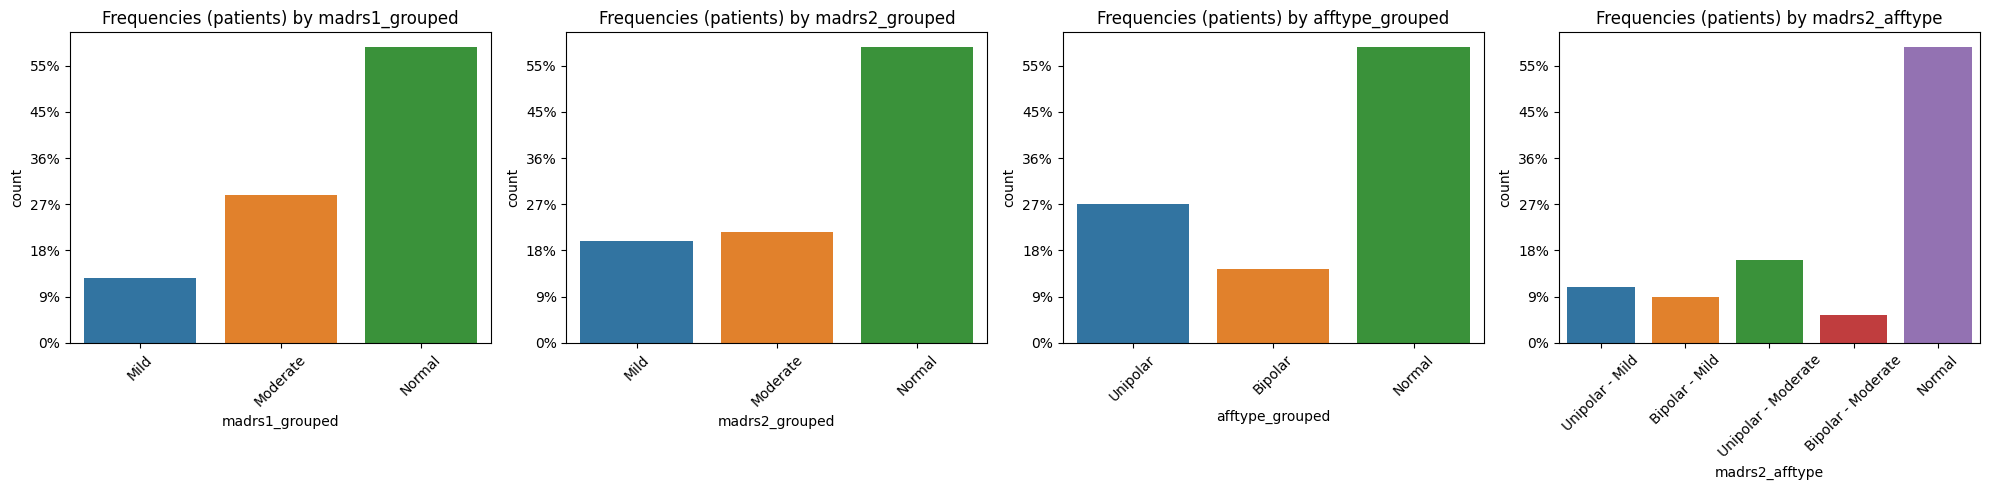

In [5]:
plot_frequencies(df_patients, ['madrs1_grouped', 'madrs2_grouped', 'afftype_grouped', 'madrs2_afftype'], 1, 4, (20, 5), title="Frequencies (patients) by ")

### Load time series motor activity data

In [6]:
import os
import pandas as pd

def consolidate_csv_files(condition_directory, control_directory):
    """
    Loads all CSV files in the condition and control directories into a single DataFrame.

    Params:
        condition_directory: The directory containing the condition CSV files
        control_directory: The directory containing the control CSV files

    Returns:
        A DataFrame containing all of the data from the CSV files in the condition and control directories
    """
    
    # Create an empty DataFrame to store the consolidated data
    df = pd.DataFrame()

    # Get a list of all files in the condition directory
    condition_files = os.listdir(condition_directory)

    # Iterate over each condition file
    for condition_file in condition_files:
        # Extract the number from the filename
        number = condition_file.replace('condition_', '').replace('.csv', '')
        # Read the condition file into a DataFrame
        condition_data = pd.read_csv(os.path.join(condition_directory, condition_file))
        # Add the 'number' column to the condition data
        condition_data['number'] = 'condition_' + str(number)
        # Append the condition data to the consolidated data
        df = pd.concat([df, condition_data], ignore_index=True)

    # Get a list of all files in the control directory
    control_files = os.listdir(control_directory)

    # Iterate over each control file
    for control_file in control_files:
        # Extract the number from the filename
        number = control_file.replace('control_', '').replace('.csv', '')
        # Read the control file into a DataFrame
        control_data = pd.read_csv(os.path.join(control_directory, control_file))
        # Add the 'number' column to the control data
        control_data['number'] = 'control_' + str(number)
        # Append the control data to the consolidated data
        df = pd.concat([df, control_data], ignore_index=True)

    # Change timestamp and date to datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = pd.to_datetime(df['date'])

    # Sort by number and timestamp
    df = df.sort_values(by=['number', 'timestamp'])

    # Reindex
    df = df.reset_index(drop=True)

    return df

df_motor = consolidate_csv_files('../../data/raw/condition', '../../data/raw/control')

### Merge patient-level and time-series data

In [7]:
# Merge the patient-level data with the time-series data
df_merged = pd.merge(df_patients, df_motor, on=['number'])
df_merged.head()

number  days gender    age afftype melanch inpatient   edu marriage  \
0  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   
1  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   
2  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   
3  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   
4  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   

  work  madrs1  madrs2 madrs1_grouped madrs2_grouped afftype_grouped  \
0  2.0    19.0    19.0           Mild           Mild        Unipolar   
1  2.0    19.0    19.0           Mild           Mild        Unipolar   
2  2.0    19.0    19.0           Mild           Mild        Unipolar   
3  2.0    19.0    19.0           Mild           Mild        Unipolar   
4  2.0    19.0    19.0           Mild           Mild        Unipolar   

    madrs2_afftype           timestamp       date  activity  
0  Unipolar - Mild 2003-05-07 12:00:00 2003-05-07         0  
1  Unipolar - Mild 2003-05-07 12:01:00 2003-05-07       143  
2  Unipolar - Mild 2003-05-07 12:02:00 2003-05-07         0  
3  Unipolar - Mild 2003-05-07 12:03:00 2003-05-07        20  
4  Unipolar - Mild 2003-05-07 12:04:00 2003-05-07       166

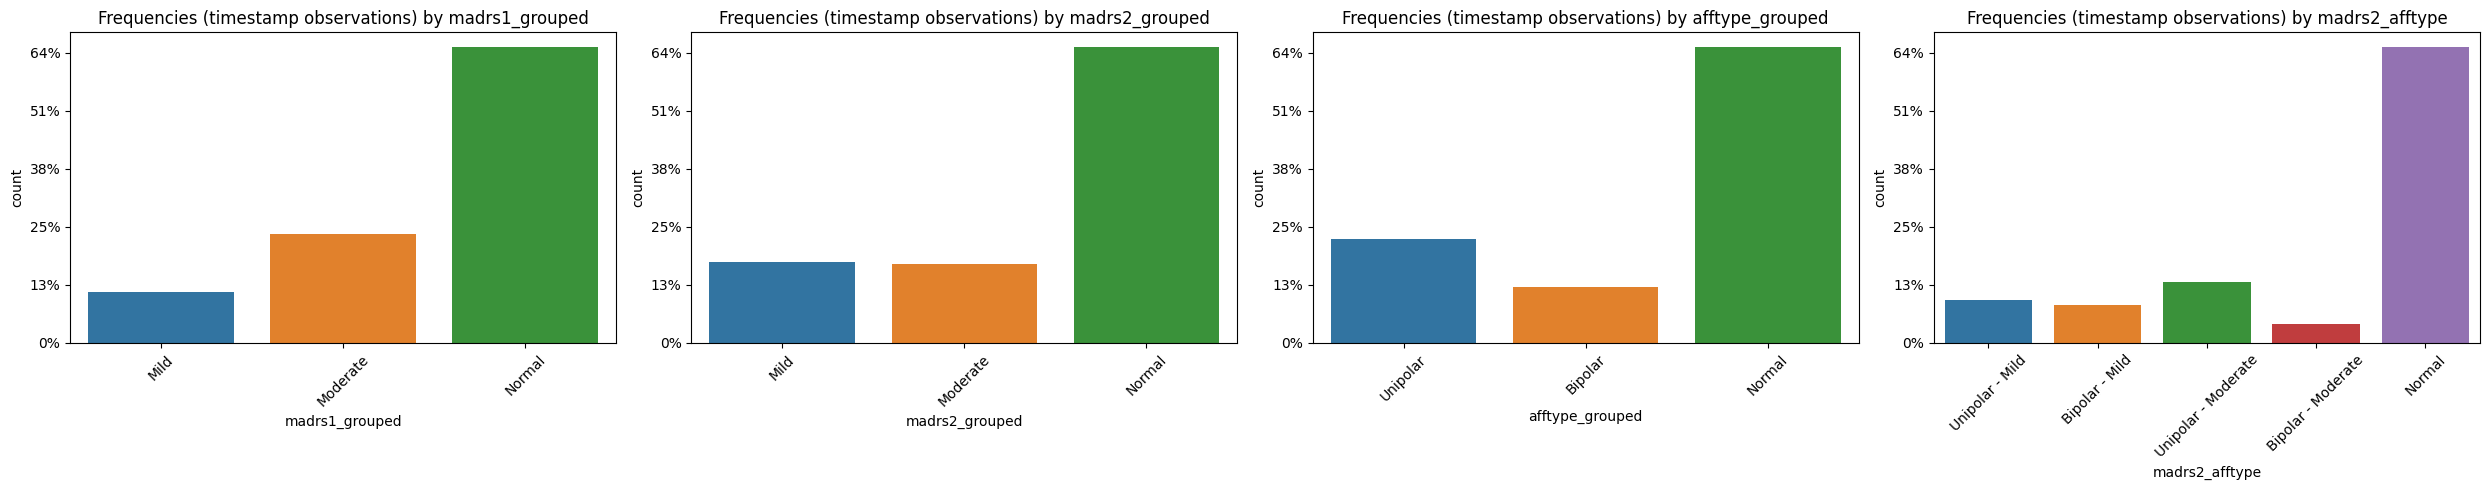

In [8]:
plot_frequencies(df_merged, ['madrs1_grouped', 'madrs2_grouped', 'afftype_grouped', 'madrs2_afftype'], 1, 4, (25, 5), title="Frequencies (timestamp observations) by ")

We will be using madrs2_grouped as the label as it has the least class imbalance

### Derive date-time values from timestamp

In [9]:
# Calculate minute of day, minute of week, minute, hour, day, day of week, week of year, month, and year from timestamp
df_merged['minute_of_day'] = df_merged['timestamp'].dt.hour * 60 + df_merged['timestamp'].dt.minute
df_merged['minute_of_week'] = df_merged['timestamp'].dt.dayofweek * 24 * 60 + df_merged['timestamp'].dt.hour * 60 + df_merged['timestamp'].dt.minute
df_merged['minute'] = df_merged['timestamp'].dt.minute
df_merged['hour'] = df_merged['timestamp'].dt.hour
df_merged['day'] = df_merged['timestamp'].dt.day
df_merged['day_of_week'] = df_merged['timestamp'].dt.dayofweek
df_merged['week_of_year'] = df_merged['timestamp'].dt.isocalendar().week
df_merged['month'] = df_merged['timestamp'].dt.month
df_merged['year'] = df_merged['timestamp'].dt.year

# Calculate minute, hour and day after first timestamp
df_merged['minute_after_first'] = df_merged.groupby('number')['timestamp'].rank(method='first')
df_merged['hour_after_first'] = df_merged['minute_after_first'] // 60
df_merged['day_after_first'] = df_merged['hour_after_first'] // 24

df_merged.head()

number  days gender    age afftype melanch inpatient   edu marriage  \
0  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   
1  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   
2  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   
3  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   
4  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   

  work  ...  minute  hour day day_of_week week_of_year month  year  \
0  2.0  ...       0    12   7           2           19     5  2003   
1  2.0  ...       1    12   7           2           19     5  2003   
2  2.0  ...       2    12   7           2           19     5  2003   
3  2.0  ...       3    12   7           2           19     5  2003   
4  2.0  ...       4    12   7           2           19     5  2003   

  minute_after_first  hour_after_first  day_after_first  
0                1.0               0.0              0.0  
1                2.0               0.0              0.0  
2                3.0               0.0              0.0  
3                4.0               0.0              0.0  
4                5.0               0.0              0.0  

[5 rows x 31 columns]

### Remove rows with invalid timestamps

In [10]:
# Remove rows where day_after_first is greater than 'days'
print(df_merged.shape)
df_merged = df_merged[df_merged['day_after_first'] <= df_merged['days']]
print(df_merged.shape)

(1571706, 31)
(1077065, 31)


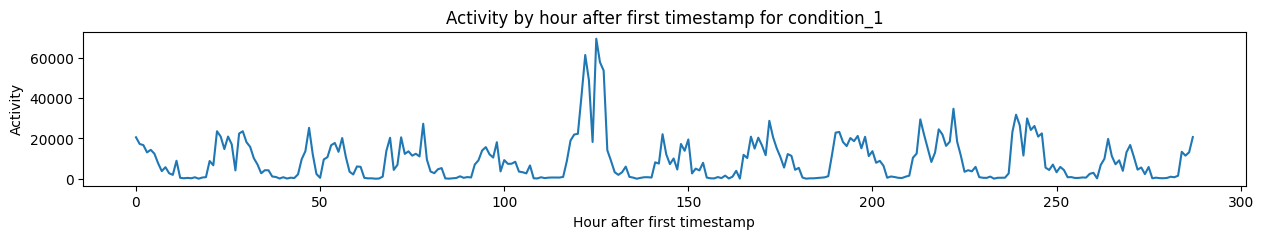

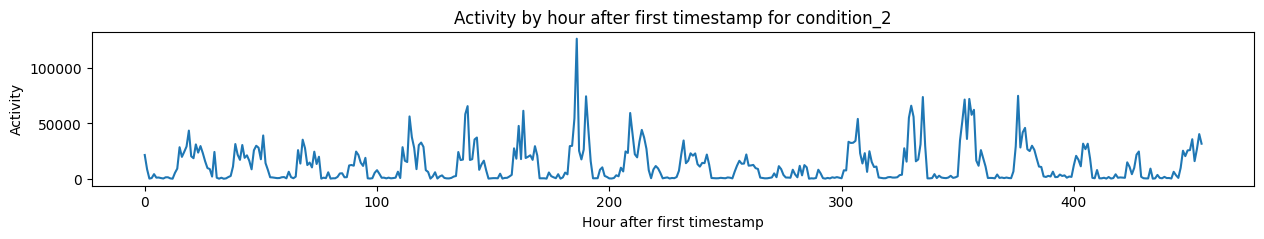

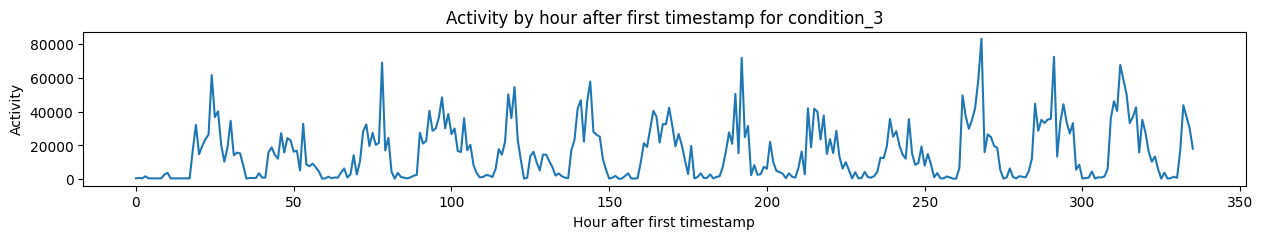

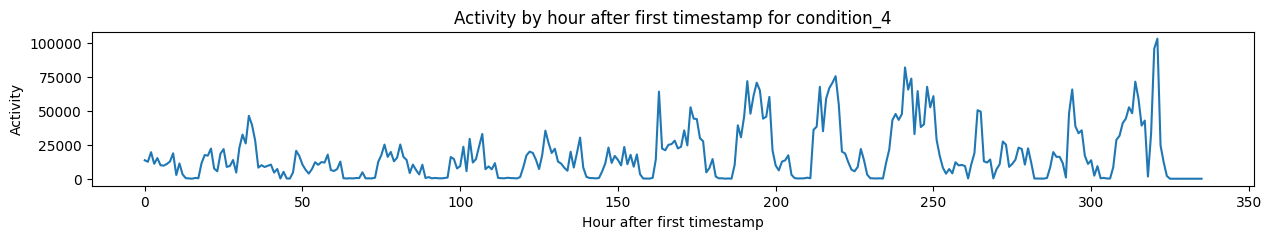

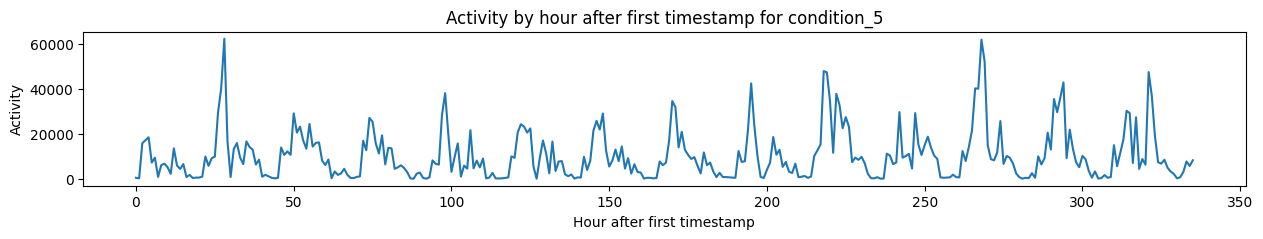

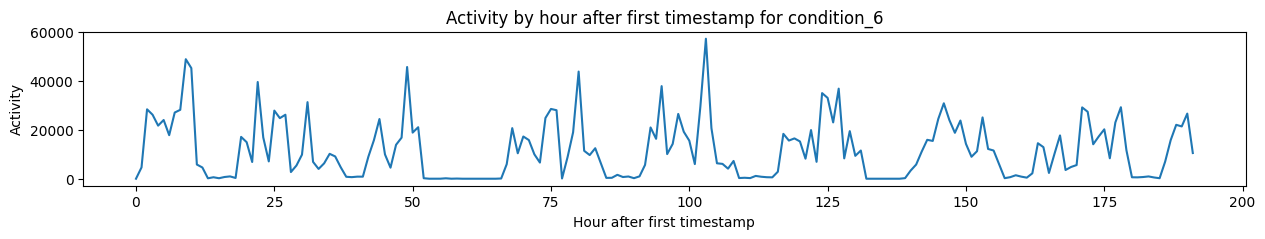

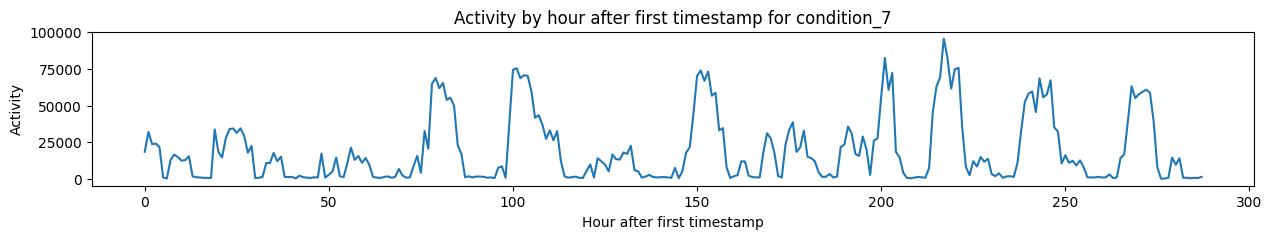

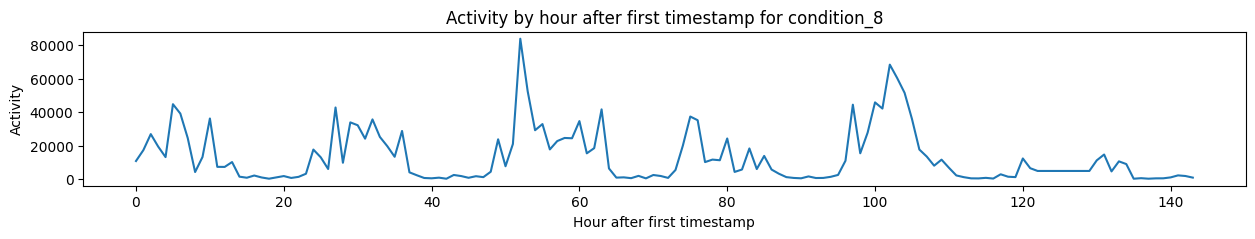

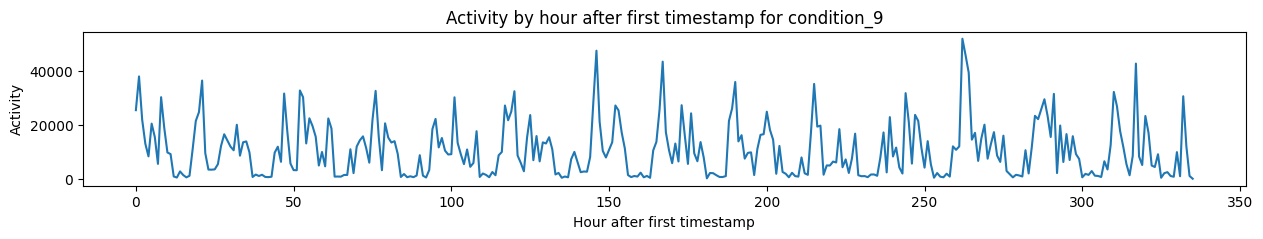

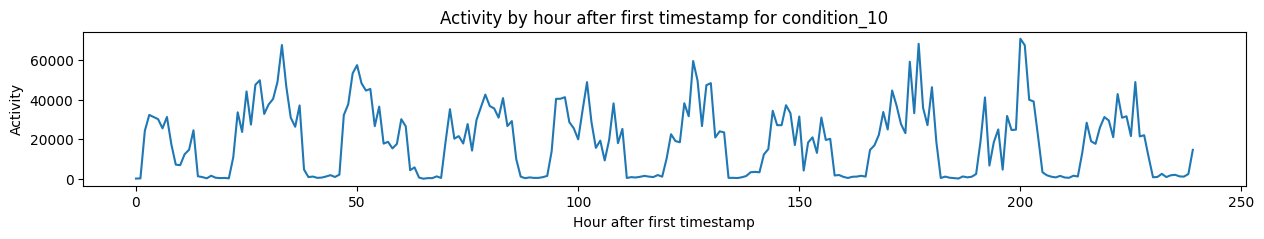

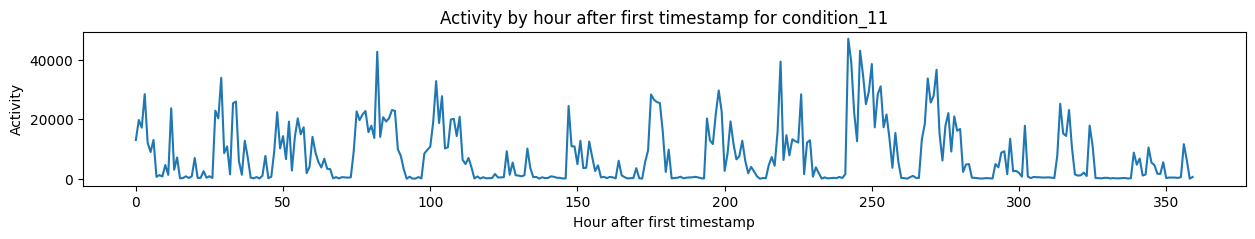

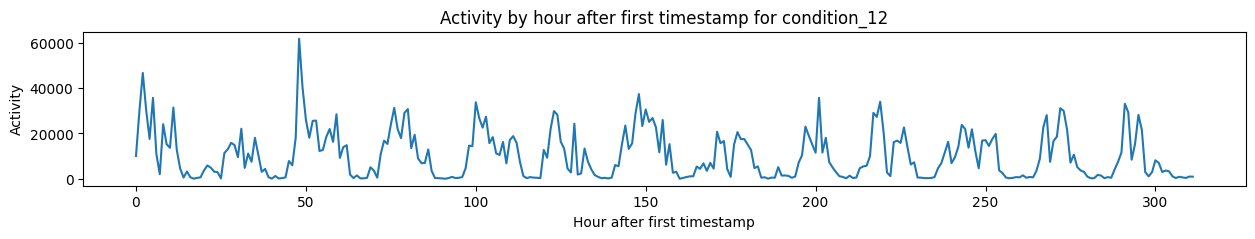

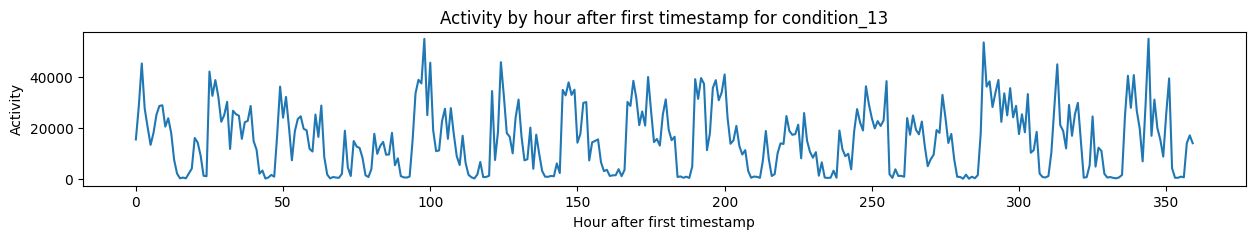

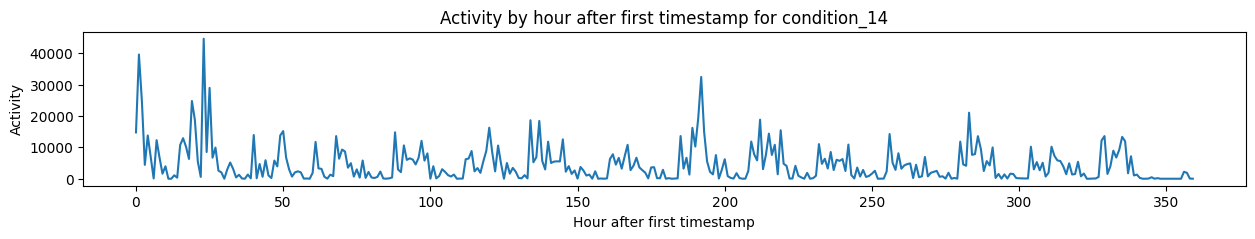

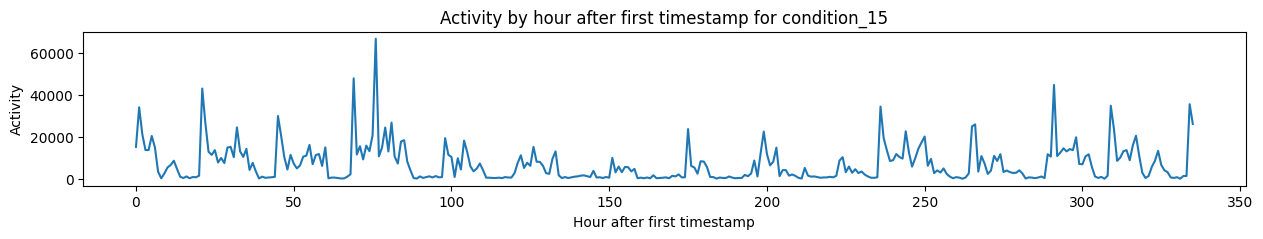

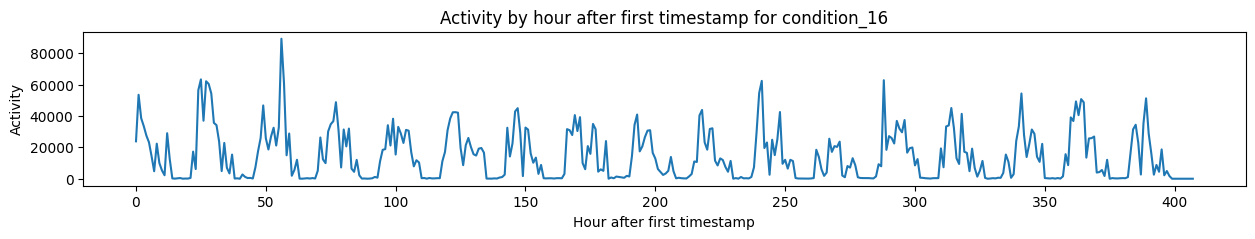

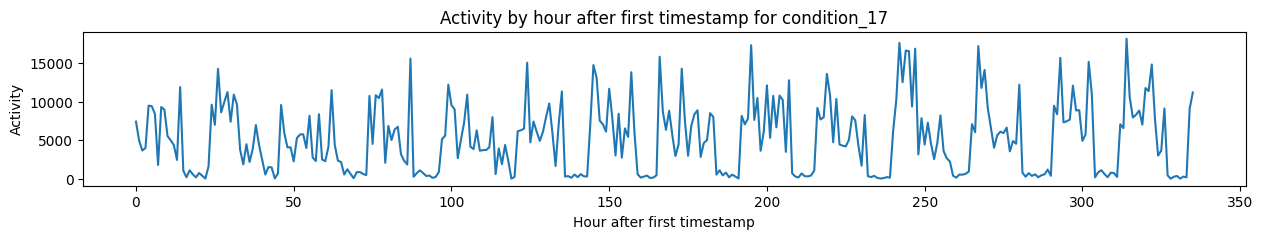

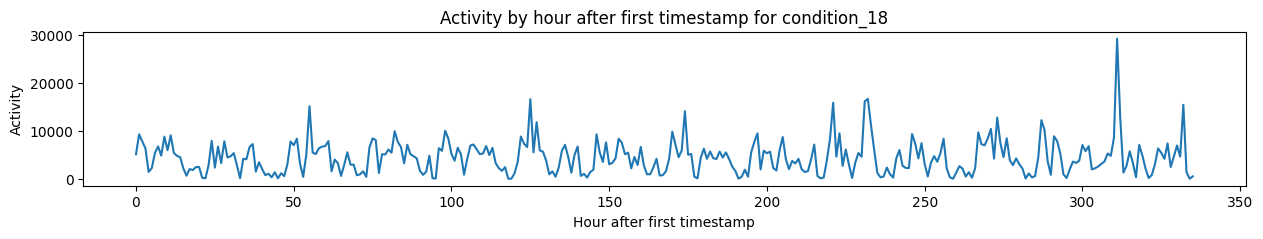

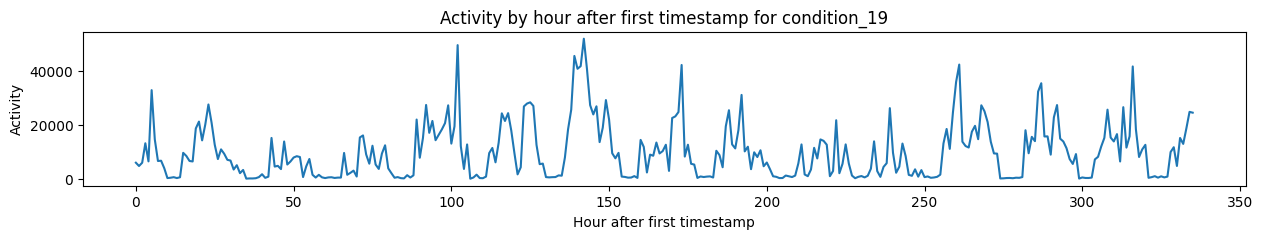

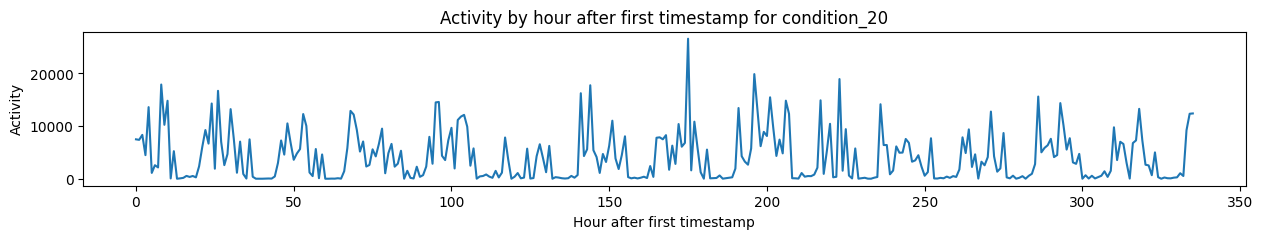

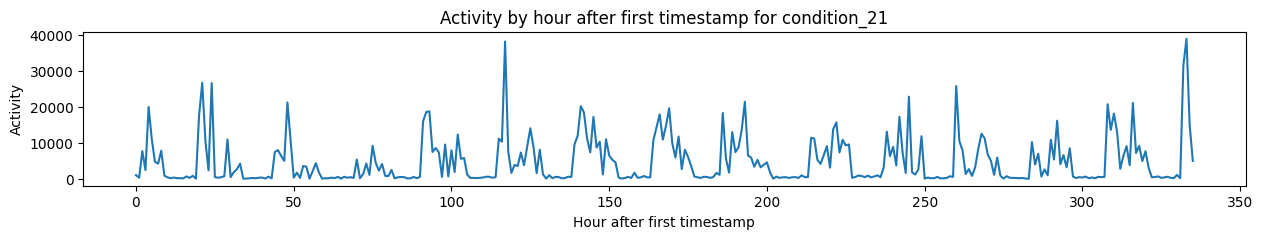

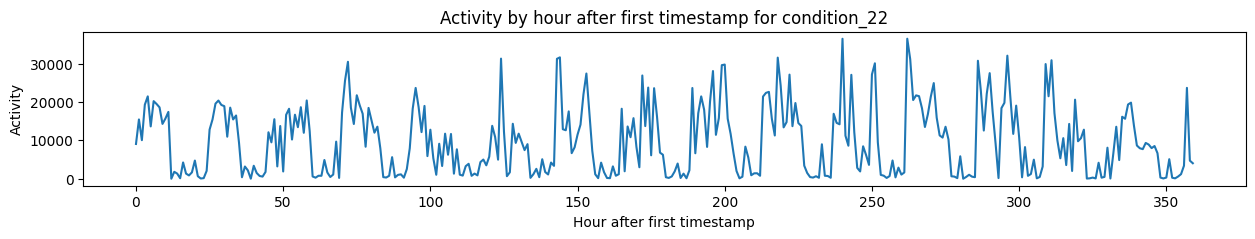

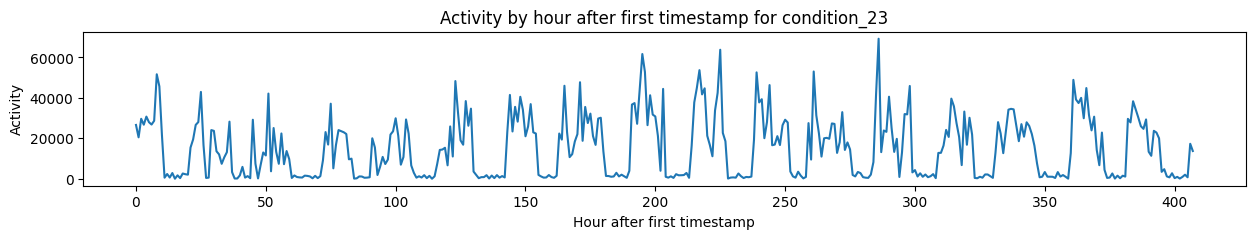

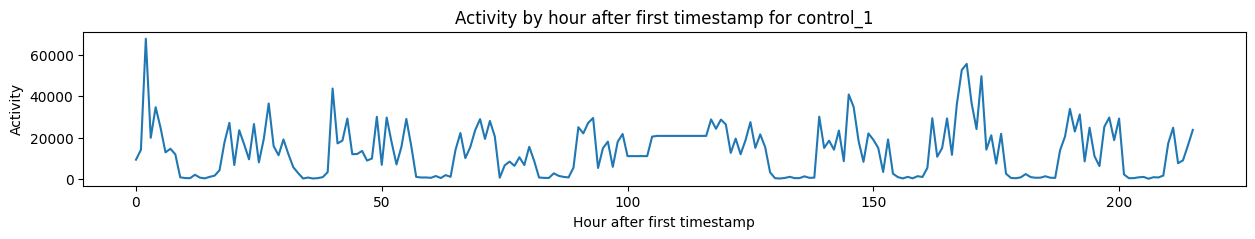

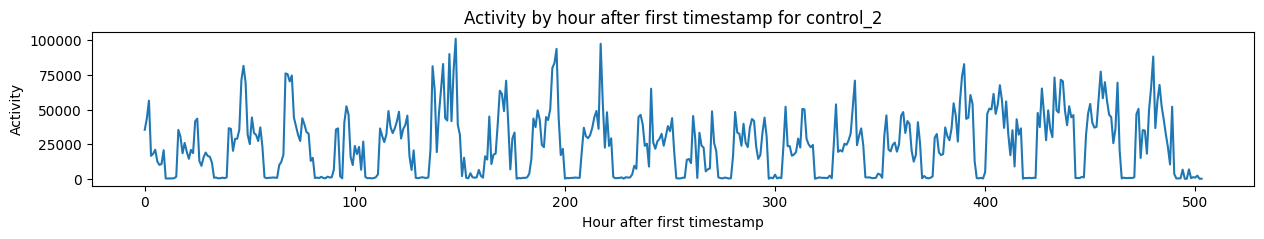

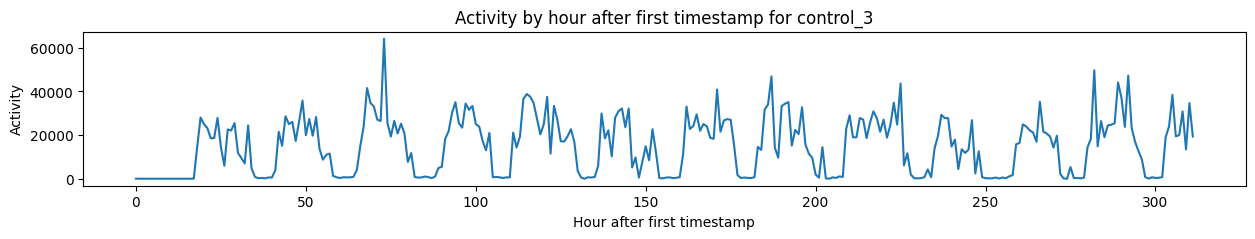

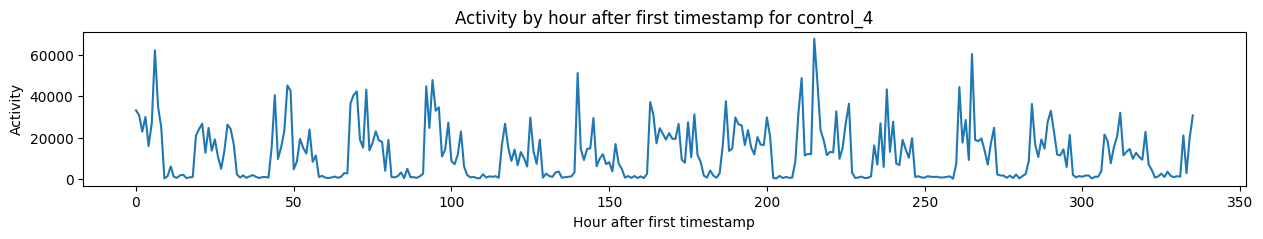

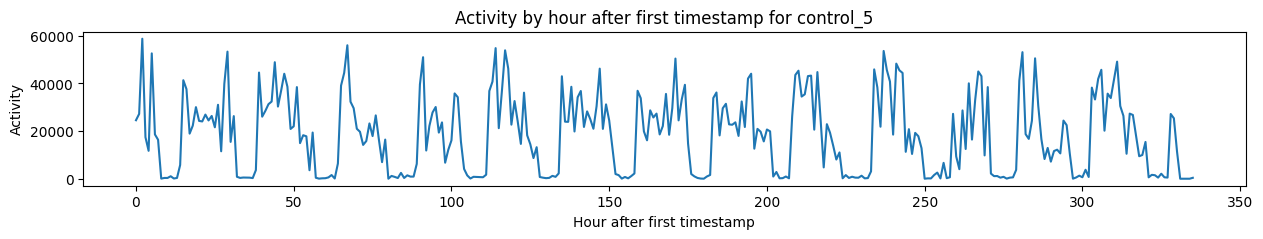

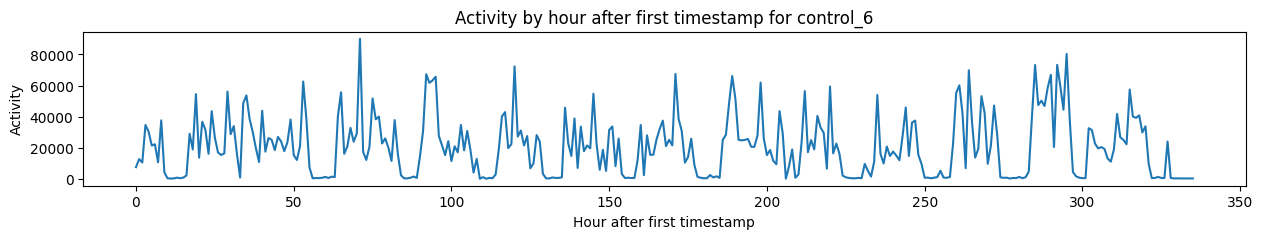

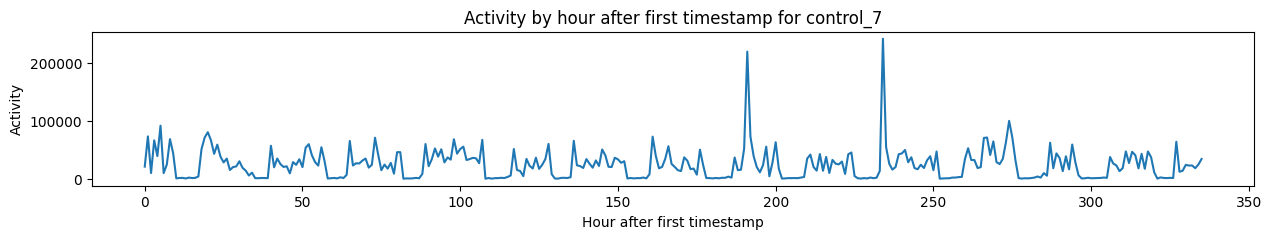

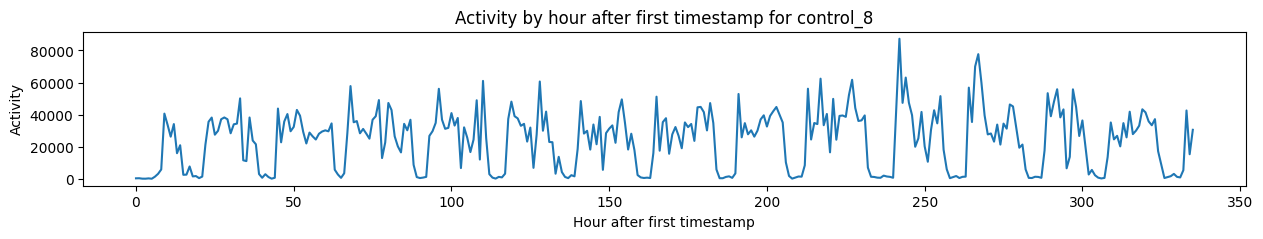

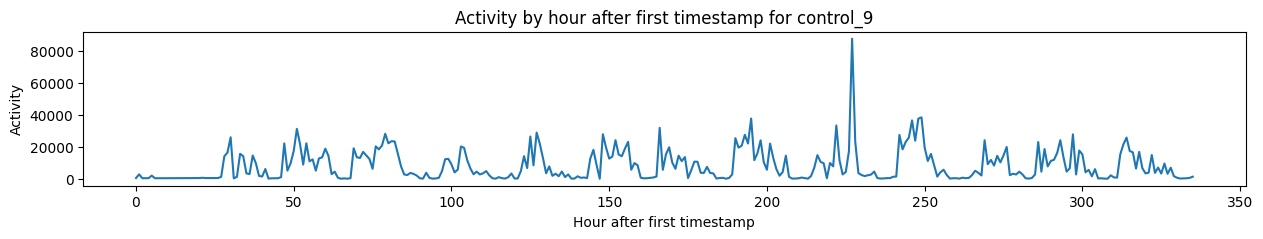

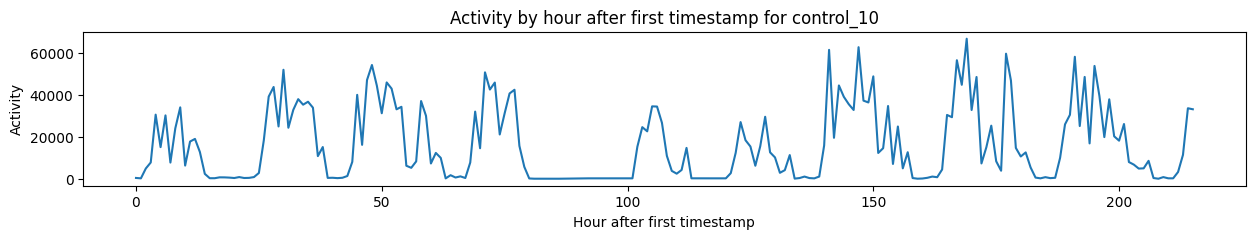

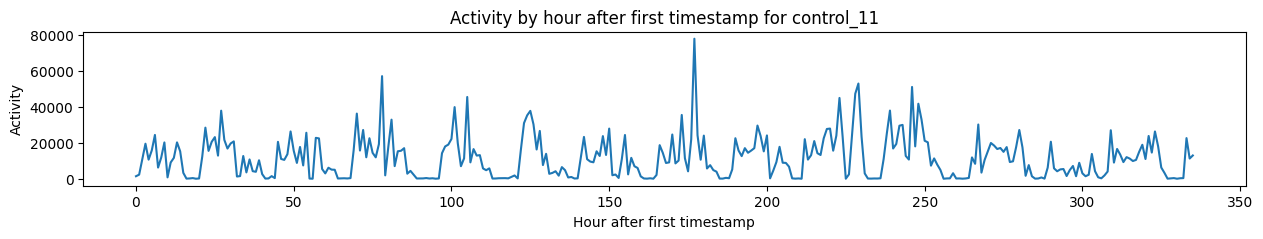

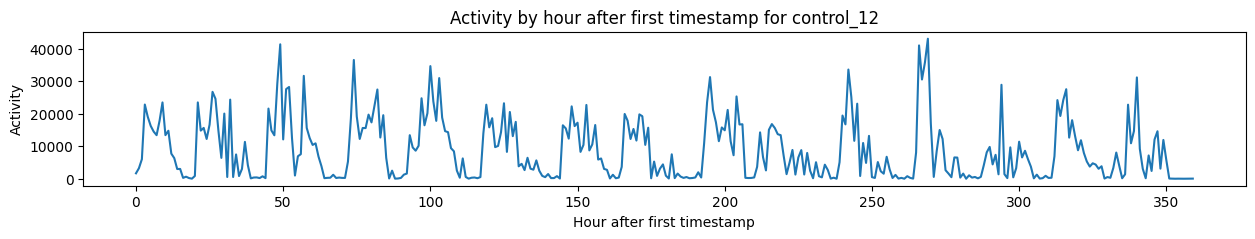

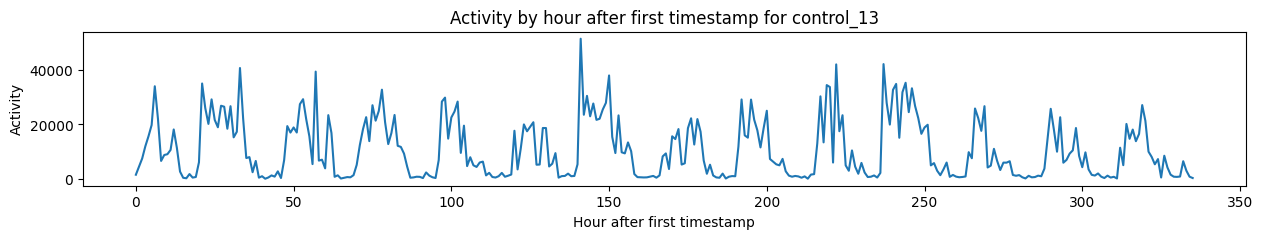

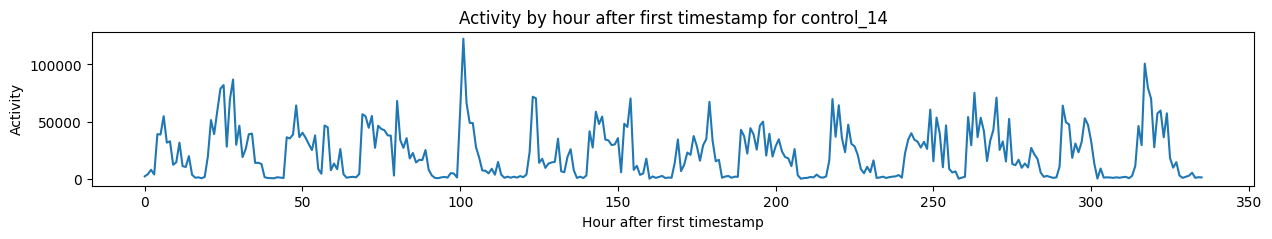

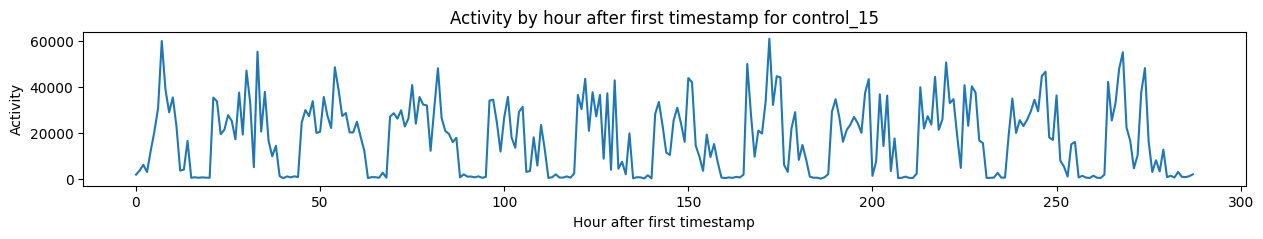

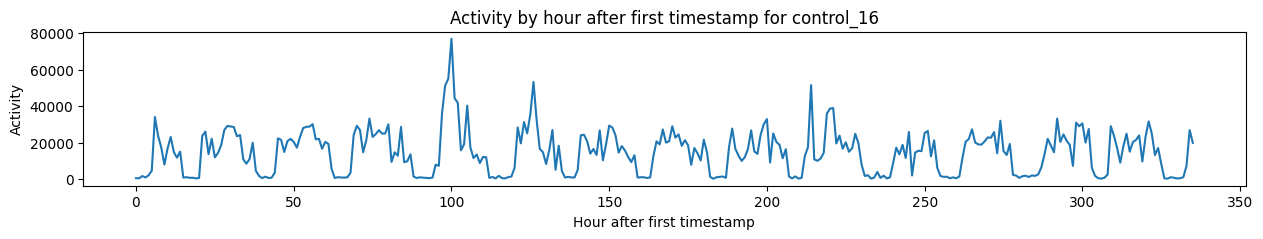

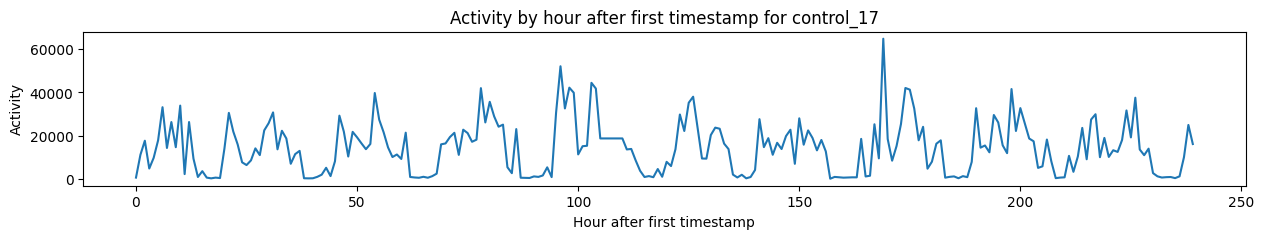

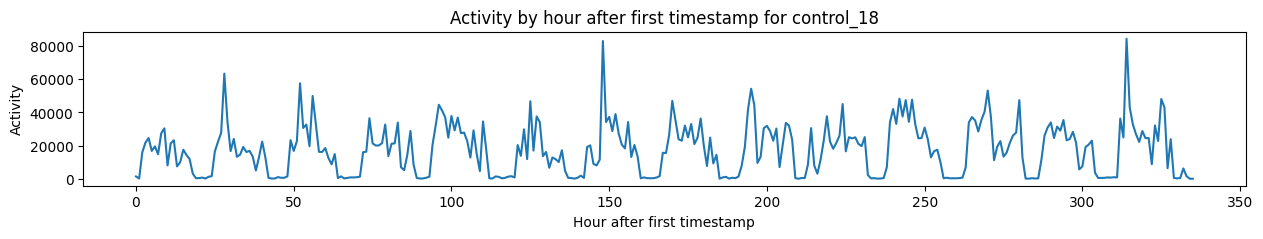

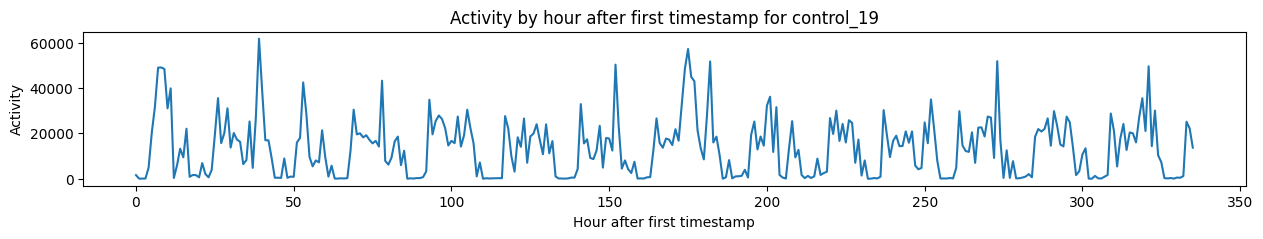

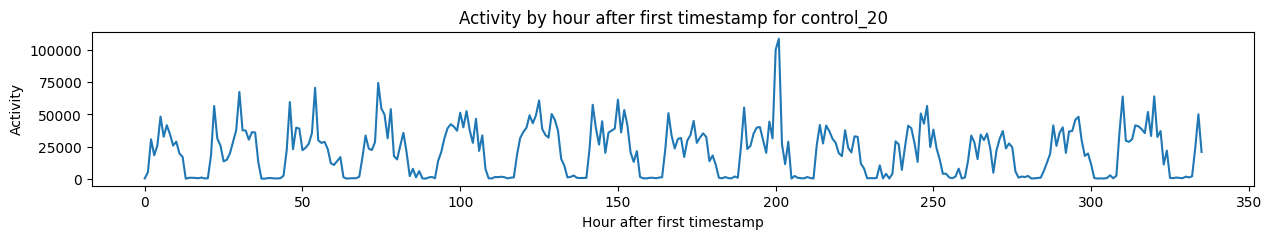

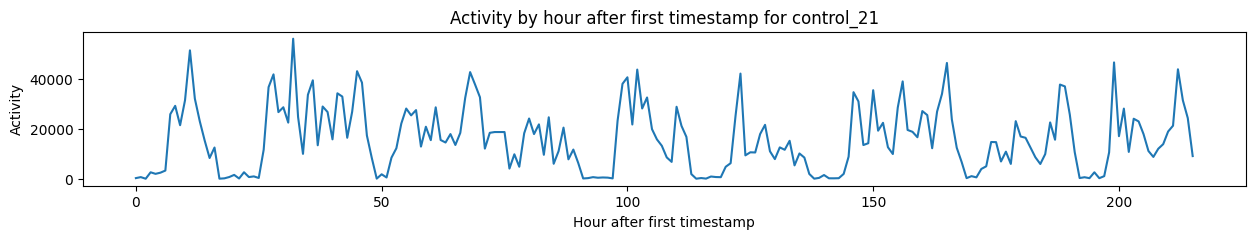

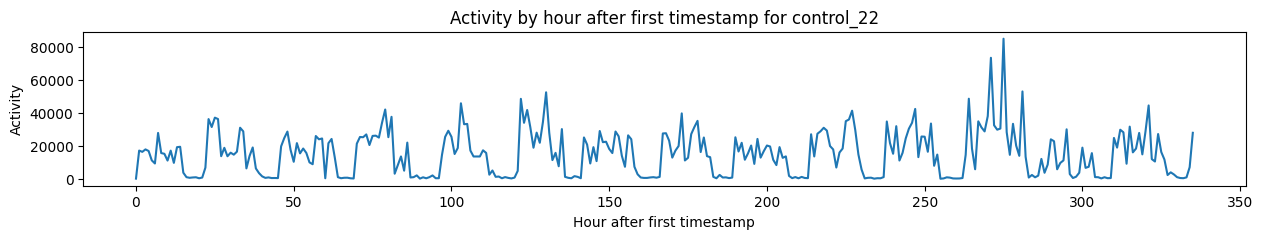

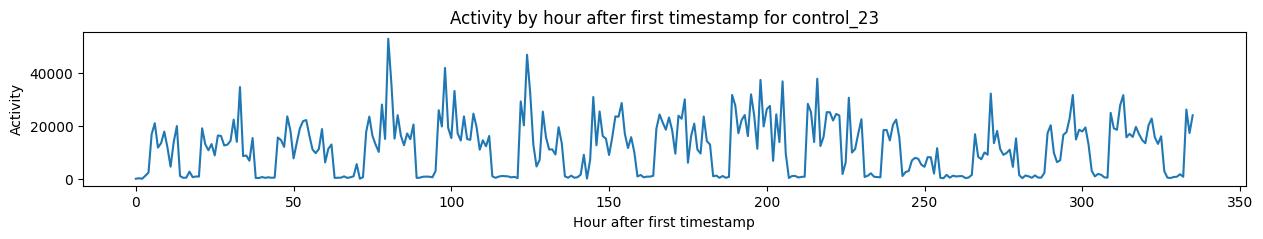

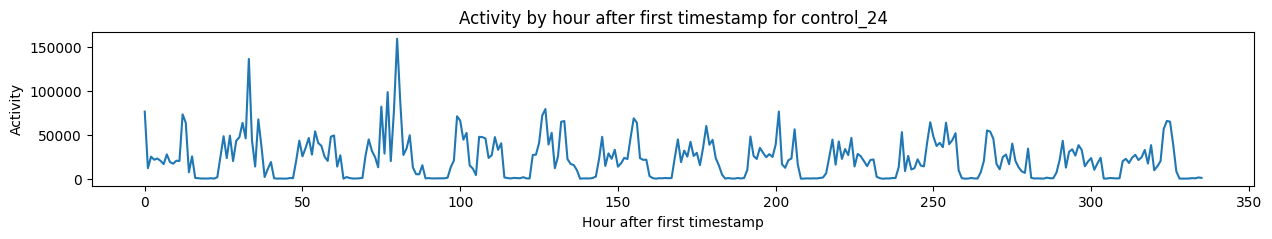

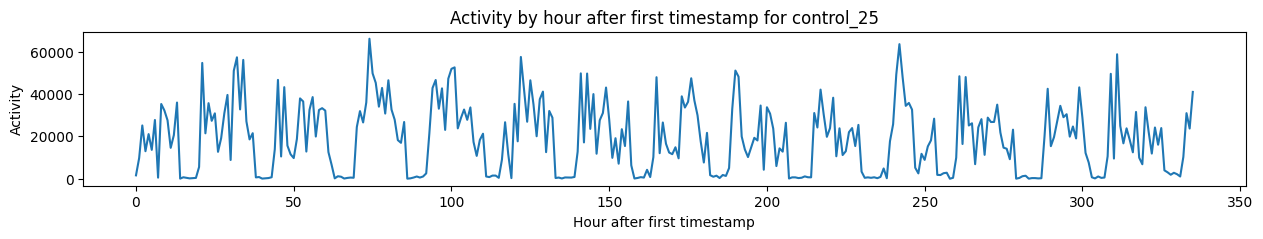

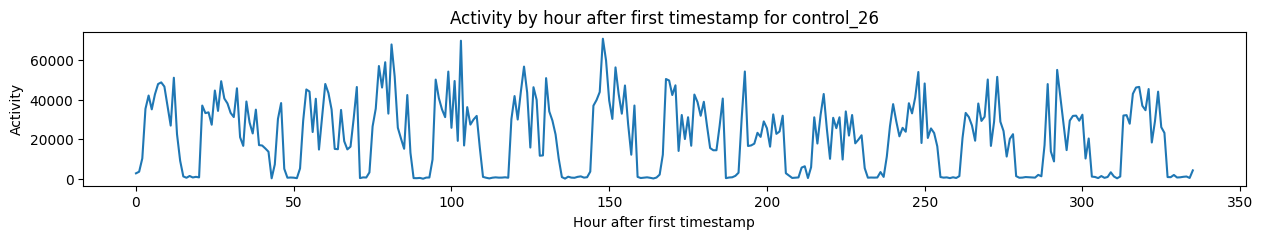

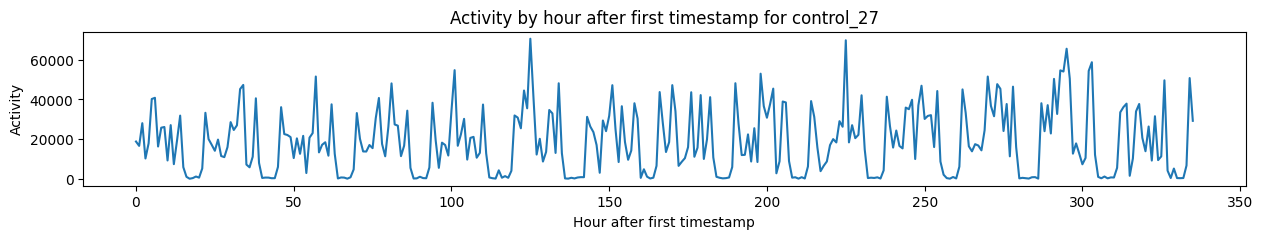

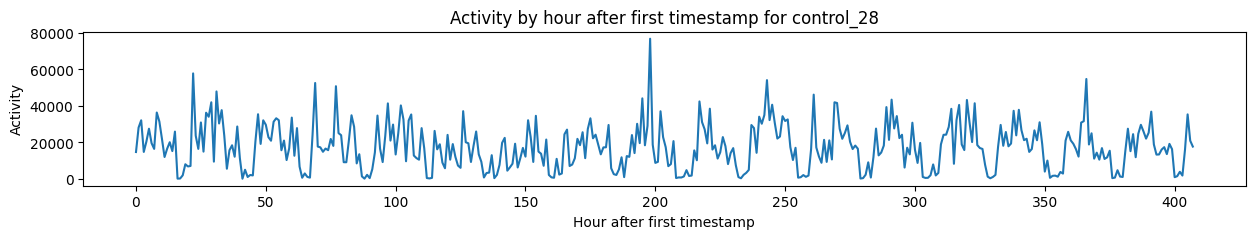

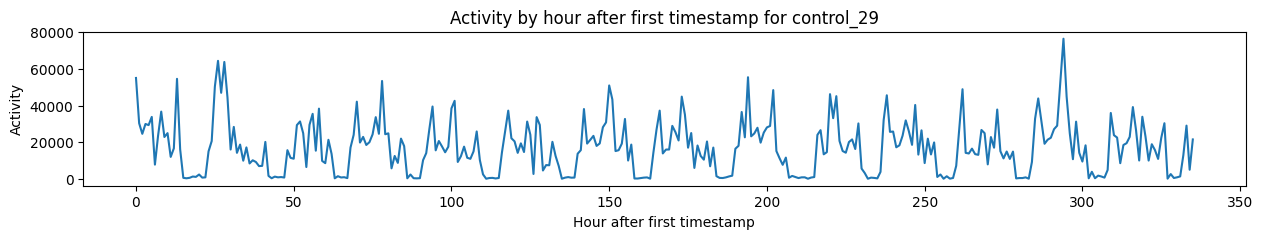

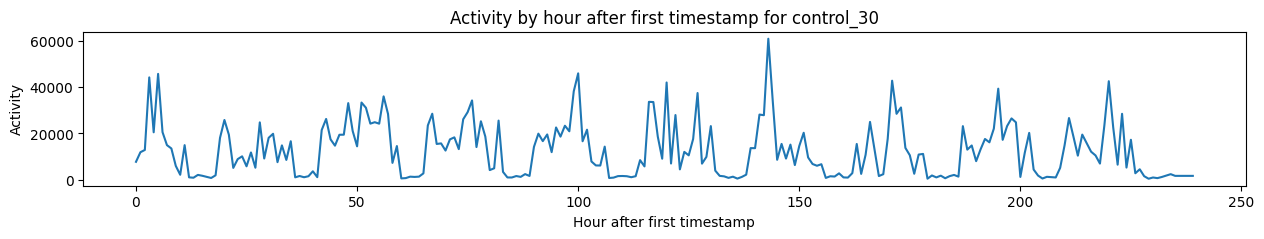

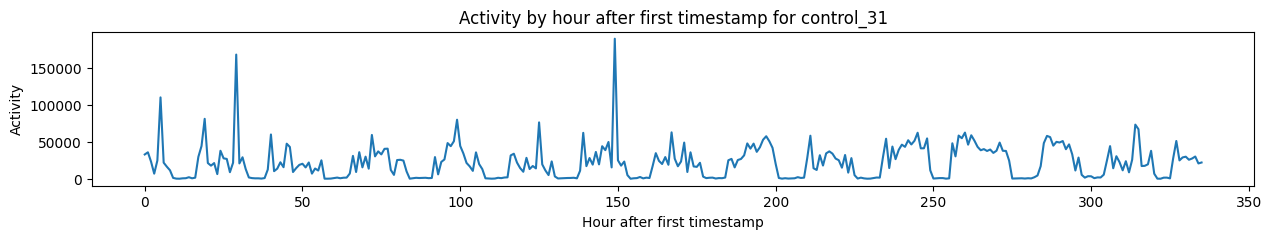

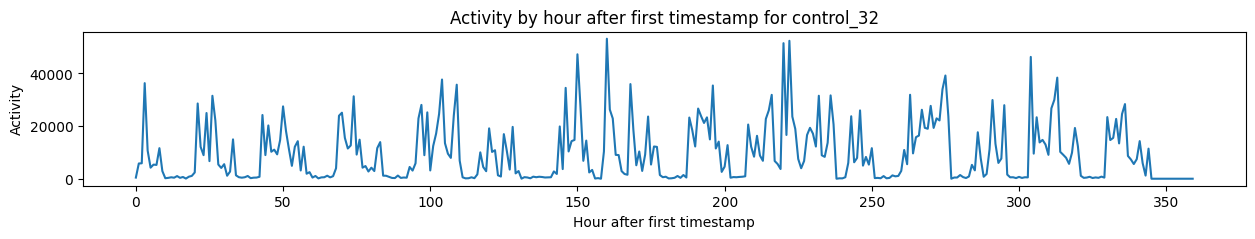

In [11]:
plot_activity_by_hour(df_merged, 'hour_after_first')

### Visualise distribution of activity by time and group

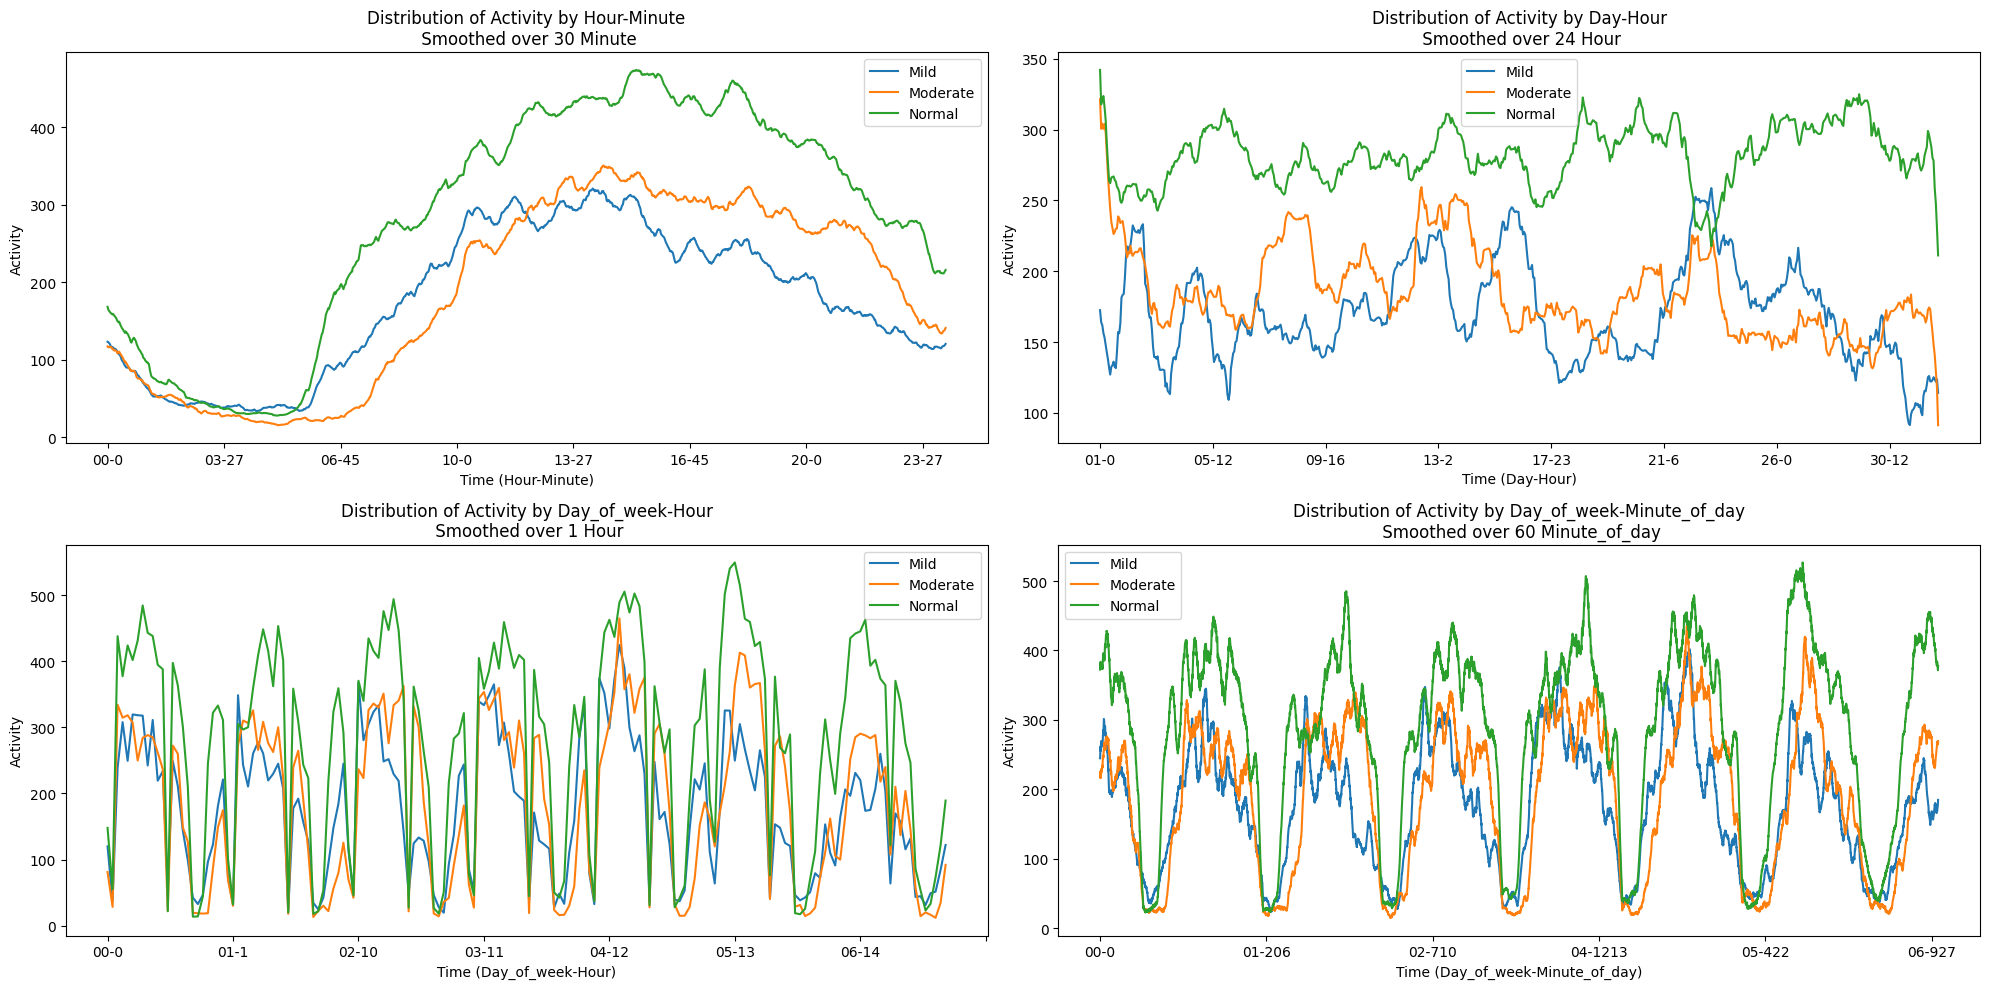

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
axs = axs.ravel()

time_activity_plot_combo(df_merged, 'hour', 'minute', 30, axs[0]) # Smooth over 30 minutes
time_activity_plot_combo(df_merged, 'day', 'hour', 24, axs[1]) # Smooth over 24 hours
time_activity_plot_combo(df_merged, 'day_of_week', 'hour', 1, axs[2]) # No smoothing
time_activity_plot_combo(df_merged, 'day_of_week', 'minute_of_day', 60, axs[3]) # Smooth over 60 minutes

plt.tight_layout()

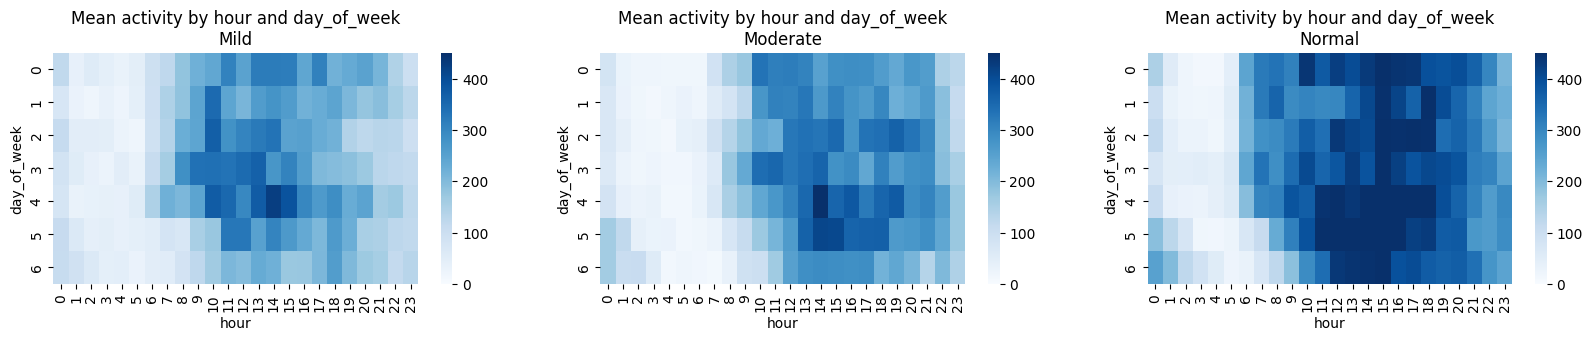

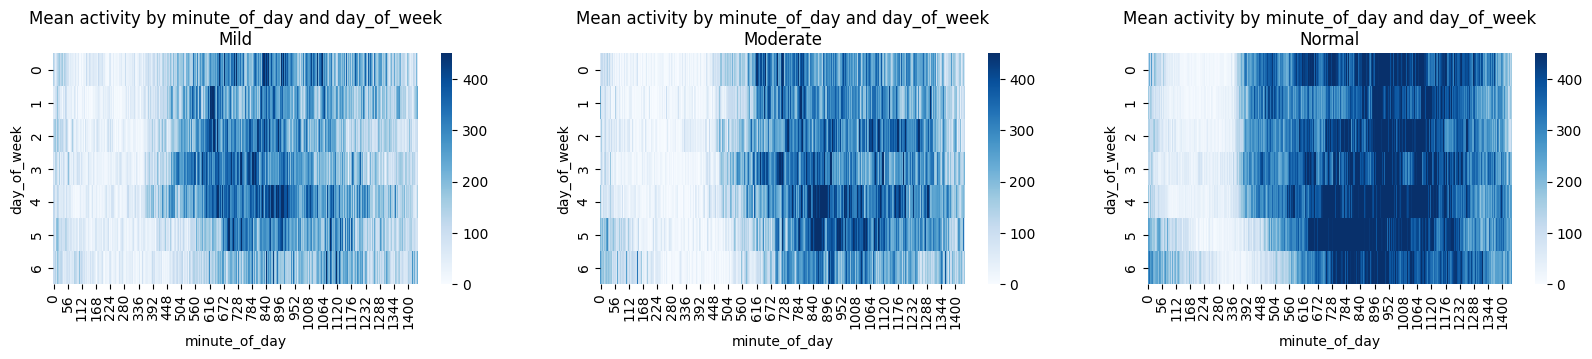

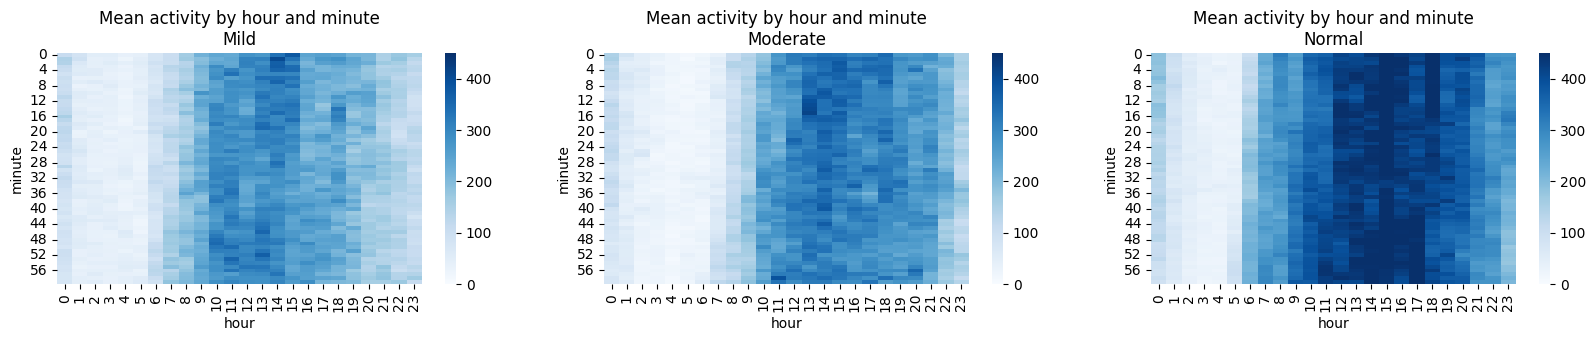

In [13]:
plot_activity_heatmap(df_merged, 'hour', 'day_of_week')
plot_activity_heatmap(df_merged, 'minute_of_day', 'day_of_week')
plot_activity_heatmap(df_merged, 'hour', 'minute')

Notes: notes:
- Week of year or month doesn't seem to be meaningful
- Cyclicality by day of the week and hour/minute of day - potentially could derive parameters for a sin/cos equation as features?
- Moderate patients seem to start being active in the day later
- Both mild and moderate depression patients have a shorter window of time during the day when they are active
- Bigger variation in activity between days of the week for depressed patients
- Peak activity by hour is equal across the groups
- Given most patient's activity is in the 11-13 day mark, analysis should be on a day_of_week or hourly or minute level
- Patterns differ by day of the week. May need to extract features by minute depending on day of the week

### Add one hot and ordinal encodings for madrs2_grouped to df_merged

In [14]:
# Add one hot encoding for madrs2_grouped while keeping original column
df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['madrs2_grouped'])], axis=1)

# Add ordinal encodings where normal = 0, mild = 1, and moderate = 2
madrs2_group_mapping = {'Normal': 0,
                        'Mild': 1,
                        'Moderate': 2}

df_merged['madrs2_grouped_ord'] = df_merged['madrs2_grouped'].map(madrs2_group_mapping)

## Data Augmentation

## Feature Extraction

### Extract features from time series data

We will extract the following features, based on rationale from literature:

1. **Interdaily stability**: Interdaily stability is a measure of the strength of circadian rhythmicity, the degree of consistency of activity patterns from one day to the next. It is calculated as the ratio of the variance of the average 24-hour pattern around the mean to the overall variance. This feature has been found to be useful in discriminating between depressed patients and healthy controls[1][2][3][4]. A study found that depressed patients had lower interdaily stability compared to healthy controls, indicating a less stable activity pattern[1].

1. **Intraday variability**: Intraday variability is a measure of the variability of the activity level within a day. It quantifies the frequency and extent of transitions between periods of rest and activity on an hourly basis. High intraday variability values indicate the occurrence of daytime naps and/or nocturnal activity episodes. This feature has been found to be useful in discriminating between depressed patients and healthy controls[3]. A study found that depressed patients had higher intraday variability compared to healthy controls, indicating a more fragmented activity pattern[3].

1. **Statistical metrics for activity levels**: These features capture different aspects of the activity level of the patients, such as mean activity, standard deviation of activity, skewness of activity, kurtosis of activity, and entropy of activity. They have been found to be useful in discriminating between depressed patients and healthy controls[1][5][3]. For example, a study found that depressed patients had lower mean activity levels and higher variability of activity levels compared to healthy controls, indicating a less active lifestyle[5].

1. **Distribution of activity occurring at different times**: This feature captures the distribution of activity occurring at different times, such as day vs. night and weekday vs. weekend. It has been found to be important for accurately classifying depression status, as there are differences in activity patterns between these periods[1][3][4]. For example, a study found that depressed patients had lower activity levels during the day and higher activity levels during the night compared to healthy controls, indicating a disrupted circadian rhythm[4].

1. **Cosine function parameters for activity**: Cosine function parameters, including amplitude, phase, baseline, and frequency, could be useful features in analyzing time series motor actigraphy data to classify patients into normal, mild, or moderate depression. Cosine models are used to map the circadian activity rhythm to activity data, and the evaluation of circadian rhythms typically involves determining the amplitude and phase of the rhythm per cycle using methods such as cosine fitting. [6][7][8]

1. **Statistical metrics for activity bouts and inactivity bouts**: These features capture different aspects of the activity patterns of the patients, such as the number of bouts, mean bout duration, standard deviation of bout duration, skewness of bout duration, kurtosis of bout duration, and entropy of bout duration. They have been found to be useful in discriminating between depressed patients and healthy controls[1][5][3]. For example, a study found that depressed patients had fewer and longer bouts of activity compared to healthy controls, indicating a less active lifestyle[5].


Overall, these features capture different aspects of the activity patterns and levels of the patients, and have been found to be useful in discriminating between depressed patients and healthy controls using machine learning algorithms. Interdaily stability and intraday variability are particularly relevant for discriminating between mildly depressed and moderately depressed patients, as they capture the stability and variability of the activity pattern over multiple days and within a day, respectively.

Note that statistical metrics will include:
1. Number of bouts: Captures the number of distinct periods of activity and inactivity throughout the day
1. Mean (of bout duration / activity levels)
1. Standard deviation (of bout duration / activity levels)
1. Coefficient of variation (of bout duration / activity levels): Standard deviation / mean - corrects for differences in mean by patient
1. Skewness (of bout duration / activity levels): Measures asymmetry of the distribution
1. Kurtosis (of bout duration / activity levels): Measures peakedness of distribution
1. Entropy (of bout duration / activity levels): Measures complexity of the distribution

Citations:
[1] https://www.radc.rush.edu/docs/var/detail.htm?category=Sleep+and+Circadian+Rhythms&subcategory=Sensor+device+measures&variable=is
[2] https://sleepscience.org.br/details/527/en-US/a-nonparametric-methodological-analysis-of-rest-activity-rhythm-in-type-2-diabetes
[3] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4559593/
[4] https://pure.uva.nl/ws/files/1216705/2123_22039y.pdf
[5] https://www.researchgate.net/publication/271767741_Nonparametric_methods_in_actigraphy_An_update
[6] https://tbiomed.biomedcentral.com/articles/10.1186/1742-4682-11-16
[7] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6857846/
[8] https://www.frontiersin.org/articles/10.3389/fnins.2023.1173537/full

By Perplexity at https://www.perplexity.ai/search/0055e9bc-5385-458c-bfed-953b4d6909cb

#### Activity-level features

In [15]:
def cosinor(x, amplitude, frequency, phase, baseline):
    return amplitude * np.cos(2 * np.pi * frequency * x + phase) + baseline

def fit_cosinor(df, x_col, y_col):
    """
    Fits a cosinor curve to the data and returns the parameters.
    """
    x = df[x_col]
    y = df[y_col]

    # Make initial guess
    guess_amplitude = np.std(y) * (2**0.5)
    guess_phase = 0
    guess_frequency = 1
    guess_baseline = np.mean(y)
    guess = [guess_amplitude, guess_phase, guess_frequency, guess_baseline]

    # Fit the function
    params, params_covariance = curve_fit(cosinor, x, y, p0=guess, maxfev=5000)
    amplitude, phase, frequency, baseline = params
    
    return {
        f'cos_{x_col}_amplitude': amplitude,
        f'cos_{x_col}_phase': phase,
        f'cos_{x_col}_frequency': frequency,
        f'cos_{x_col}_baseline': baseline,
    }

def interday_stability(data):
    """
    Calculates interday stability, which quantifies the variability of patterns within a 24-hour cycle across multiple days
    Interday Stability = Variance of the average 24 hour pattern / Total Variance of the Group
    """
    # Calculate average 24-hour pattern for the group
    mean_24h_pattern = data['activity'].groupby([data.timestamp.dt.hour]).mean()

    # Calculate variance of the average 24-hour pattern
    var_24h_pattern = np.var(mean_24h_pattern)

    # Calculate total variance of the group
    total_var = np.var(data['activity'])

    # Calculate Interdaily Stability for the group
    interday_stability = var_24h_pattern / total_var

    return interday_stability

def intraday_variability(data):
    """
    Calculates intraday variability, which represents the level of variability within a single day relative to average activity level for that day
    Intraday Variability = Variance of activity values within a single day / Mean activity value for that day
    """
    # Group the data by date and calculate the variance within each day
    daily_variances = data.groupby(data.timestamp.dt.date)['activity'].var()

    # Calculate the mean activity value for each day
    daily_means = data.groupby(data.timestamp.dt.date)['activity'].mean()

    # Calculate the intraday variability by dividing the daily variances by the daily means
    intraday_variability = np.mean(daily_variances / daily_means)

    return intraday_variability

def pct_day_activity(data, hour_start, hour_end):
    """
    Calculate the percentage of activity occurring in a time window (e.g., 08:00-12:00)
    """
    # Calculate sum of activity
    total_activity = data['activity'].sum()
    
    if hour_start < hour_end:
        window_activity = data[data['timestamp'].dt.hour.between(hour_start, hour_end)]['activity'].sum()
    else: 
        window_activity = data[(data['timestamp'].dt.hour >= hour_start) | (data['timestamp'].dt.hour < hour_end)]['activity'].sum()

    # Calculate percentage of activity during each window
    pct_activity = window_activity / total_activity if total_activity > 0 else 0

    return pct_activity

def pct_weekday_activity(data):
    """
    Calculate the percentage of activity occurring in weekdays
    """
    # Calculate sum of activity
    total_activity = data['activity'].sum()

    window_activity = data[data['timestamp'].dt.dayofweek.between(0,4)]['activity'].sum()

    # Calculate percentage of activity during selected days
    pct_activity = window_activity / total_activity if total_activity > 0 else 0

    return pct_activity

def mean_activity_window(data, hour_start, hour_end, weekdays=True):
    """
    Calculate mean activity during a time window (e.g., 08:00-12:00) for specific days of the week
    (e.g., weekdays, weekends, Mondays, Tuesdays, etc.)
    """
    if weekdays:
        # filter data to only include weekdays
        data = data[data['timestamp'].dt.dayofweek.between(0, 4)]
        if hour_start < hour_end:
            mean_activity = data[data['timestamp'].dt.hour.between(hour_start, hour_end)]['activity'].mean()
        else:
            mean_activity = data[(data['timestamp'].dt.hour >= hour_start) | (data['timestamp'].dt.hour < hour_end)]['activity'].mean()
    else:
        # filter data to only include weekends
        data = data[data['timestamp'].dt.dayofweek.between(5, 6)]
        if hour_start < hour_end:
            mean_activity = data[data['timestamp'].dt.hour.between(hour_start, hour_end)]['activity'].mean()
        else:
            mean_activity = data[(data['timestamp'].dt.hour >= hour_start) | (data['timestamp'].dt.hour < hour_end)]['activity'].mean()

    return mean_activity

In [16]:
def calculate_activity_features(data):
    """
    Group data by number and calculate activity-based features for each number
    """

    # Create an empty DataFrame to store the features
    df = pd.DataFrame()

    # Get madrs2_grouped values for each number
    df['madrs2_grouped'] = data.groupby('number')['madrs2_grouped'].first()
    df['madrs2_grouped_ord'] = data.groupby('number')['madrs2_grouped_ord'].first()
    df['Normal'] = data.groupby('number')['Normal'].first()
    df['Mild'] = data.groupby('number')['Mild'].first()
    df['Moderate'] = data.groupby('number')['Moderate'].first()
       
    # Interday stability
    df['activity_interday_stability'] = data.groupby('number').apply(interday_stability)
    
    # Intradaily variability
    df['activity_intraday_variability'] = data.groupby('number').apply(intraday_variability)

    # Mean activity
    df['activity_mean'] = data.groupby('number')['activity'].mean()

    # Mean activity for different times of the week
    # Create a for loop to calculate mean activity for different times of the week
    for weekdays in [True, False]:
        for hour_start, hour_end in [(0, 6), (6, 12), (12, 18), (18, 0)]:
            if weekdays:
                df[f'activity_mean_weekdays_{hour_start}to{hour_end}'] = data.groupby('number').apply(lambda x: mean_activity_window(x, hour_start=hour_start, hour_end=hour_end, weekdays=weekdays))
            else:
                df[f'activity_mean_weekends_{hour_start}to{hour_end}'] = data.groupby('number').apply(lambda x: mean_activity_window(x, hour_start=hour_start, hour_end=hour_end, weekdays=weekdays))

    # Standard deviations of activity level
    df['activity_std_minutely'] = data.groupby('number')['activity'].std()
    df['activity_std_hourly'] = data.groupby(['number', 'hour_after_first'])['activity'].var().groupby('number').std()
    df['activity_std_daily'] = data.groupby(['number', 'day_after_first'])['activity'].var().groupby('number').std()

    # Coefficient of variation of activity level
    df['activity_cv_minutely'] = df['activity_std_minutely'] / df['activity_mean']
    df['activity_cv_hourly'] = df['activity_std_hourly'] / df['activity_mean']
    df['activity_cv_daily'] = df['activity_std_daily'] / df['activity_mean']

    # Kurtosis of activity level
    df['activity_kurtosis_minutely'] = data.groupby('number')['activity'].apply(stats.kurtosis)
    df['activity_kurtosis_hourly'] = data.groupby(['number', 'hour_after_first'])['activity'].apply(stats.kurtosis).groupby('number').mean()
    df['activity_kurtosis_daily'] = data.groupby(['number', 'day_after_first'])['activity'].apply(stats.kurtosis).groupby('number').mean()

    # Skewness of activity level
    df['activity_skewness_minutely'] = data.groupby('number')['activity'].apply(stats.skew)
    df['activity_skewness_hourly'] = data.groupby(['number', 'hour_after_first'])['activity'].apply(stats.skew).groupby('number').mean()
    df['activity_skewness_daily'] = data.groupby(['number', 'day_after_first'])['activity'].apply(stats.skew).groupby('number').mean()

    # Entropy of activity level
    df['activity_entropy_minutely'] = data.groupby('number')['activity'].apply(stats.entropy)
    df['activity_entropy_hourly'] = data.groupby(['number', 'hour_after_first'])['activity'].apply(stats.entropy).groupby('number').mean()
    df['activity_entropy_daily'] = data.groupby(['number', 'day_after_first'])['activity'].apply(stats.entropy).groupby('number').mean()

    # Percentage of activity occuring on weekdays
    df['activity_pct_weekday'] = data.groupby('number').apply(pct_weekday_activity)
    
    # Percentage of activity occurring during 12-hour time windows - note to figure out the best splits to maximise the difference between groups
    df['activity_pct_0to6'] = data.groupby('number').apply(lambda x: pct_day_activity(x, 0, 6))
    df['activity_pct_6to12'] = data.groupby('number').apply(lambda x: pct_day_activity(x, 6, 12))
    df['activity_pct_12to18'] = data.groupby('number').apply(lambda x: pct_day_activity(x, 12, 18))
    df['activity_pct_18to0'] = data.groupby('number').apply(lambda x: pct_day_activity(x, 18, 24))

    # Apply the cosinor fit function and create a DataFrame with the results use minute_of_day
    cosinor_features = data.groupby('number').apply(fit_cosinor, 'minute_of_day', 'activity')
    cosinor_df = pd.DataFrame(list(cosinor_features.values), index=cosinor_features.index)

    # Concatenate the existing df with the cosinor_df
    df = pd.concat([df, cosinor_df], axis=1)

    # Apply the cosinor fit function and create a DataFrame with the results use day_of_week
    cosinor_features = data.groupby('number').apply(fit_cosinor, 'day_of_week', 'activity')
    cosinor_df = pd.DataFrame(list(cosinor_features.values), index=cosinor_features.index)

    # Concatenate the existing df with the cosinor_df
    df = pd.concat([df, cosinor_df], axis=1)
    
    # Apply the cosinor fit function and create a DataFrame with the results use minute_of_week
    cosinor_features = data.groupby('number').apply(fit_cosinor, 'minute_of_week', 'activity')
    cosinor_df = pd.DataFrame(list(cosinor_features.values), index=cosinor_features.index)

    # Concatenate the existing df with the cosinor_df
    df = pd.concat([df, cosinor_df], axis=1)
    
    return df

df_activity_features = calculate_activity_features(df_merged)
df_activity_features.head()

/Users/garykong/miniforge3/envs/w207/lib/python3.10/site-packages/pandas/core/groupby/ops.py:767: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = f(group)
/Users/garykong/miniforge3/envs/w207/lib/python3.10/site-packages/pandas/core/groupby/ops.py:767: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = f(group)
/Users/garykong/miniforge3/envs/w207/lib/python3.10/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


madrs2_grouped  madrs2_grouped_ord  Normal   Mild  Moderate  \
number                                                                     
condition_1            Mild                   1   False   True     False   
condition_10       Moderate                   2   False  False      True   
condition_11       Moderate                   2   False  False      True   
condition_12       Moderate                   2   False  False      True   
condition_13           Mild                   1   False   True     False   

              activity_interday_stability  activity_intraday_variability  \
number                                                                     
condition_1                      0.208737                     429.453604   
condition_10                     0.272192                     580.711403   
condition_11                     0.100964                     542.382958   
condition_12                     0.182716                     433.170487   
condition_13                     0.150851                     487.534039   

              activity_mean  activity_mean_weekdays_0to6  \
number                                                     
condition_1      155.345969                    13.887798   
condition_10     321.150497                    20.453869   
condition_11     132.735775                    23.998701   
condition_12     174.285592                    24.438095   
condition_13     262.156813                    86.758009   

              activity_mean_weekdays_6to12  ...  cos_minute_of_day_frequency  \
number                                      ...                                
condition_1                     176.043168  ...                     4.168127   
condition_10                    359.293540  ...                     3.674795   
condition_11                     85.350509  ...                     4.732390   
condition_12                    162.710505  ...                     4.311221   
condition_13                    345.706863  ...                     4.103254   

              cos_minute_of_day_baseline  cos_day_of_week_amplitude  \
number                                                                
condition_1                   160.226839                5397.204287   
condition_10                  298.277659                1191.783786   
condition_11                  133.096171                  70.729933   
condition_12                  174.752132                6358.945945   
condition_13                  264.646027               22560.576673   

              cos_day_of_week_phase  cos_day_of_week_frequency  \
number                                                           
condition_1                0.001851                   2.883030   
condition_10               0.000412                   1.087937   
condition_11              -0.163032                   4.079379   
condition_12               0.003688                  -0.049445   
condition_13               0.003965                  -0.052240   

              cos_day_of_week_baseline  cos_minute_of_week_amplitude  \
number                                                                 
condition_1                5421.335852                   3859.887828   
condition_10               -224.511167                 101599.366511   
condition_11                140.820300                     72.989501   
condition_12              -6176.342650                  23394.911951   
condition_13             -22266.102382                     44.173835   

              cos_minute_of_week_phase  cos_minute_of_week_frequency  \
number                                                                 
condition_1               2.855733e-06                     -0.004579   
condition_10             -9.817304e-07                      0.043430   
condition_11             -9.953791e-05                      4.115306   
condition_12             -1.627463e-06                      0.061804   
condition_13              7.850850e-05                     -2.07609

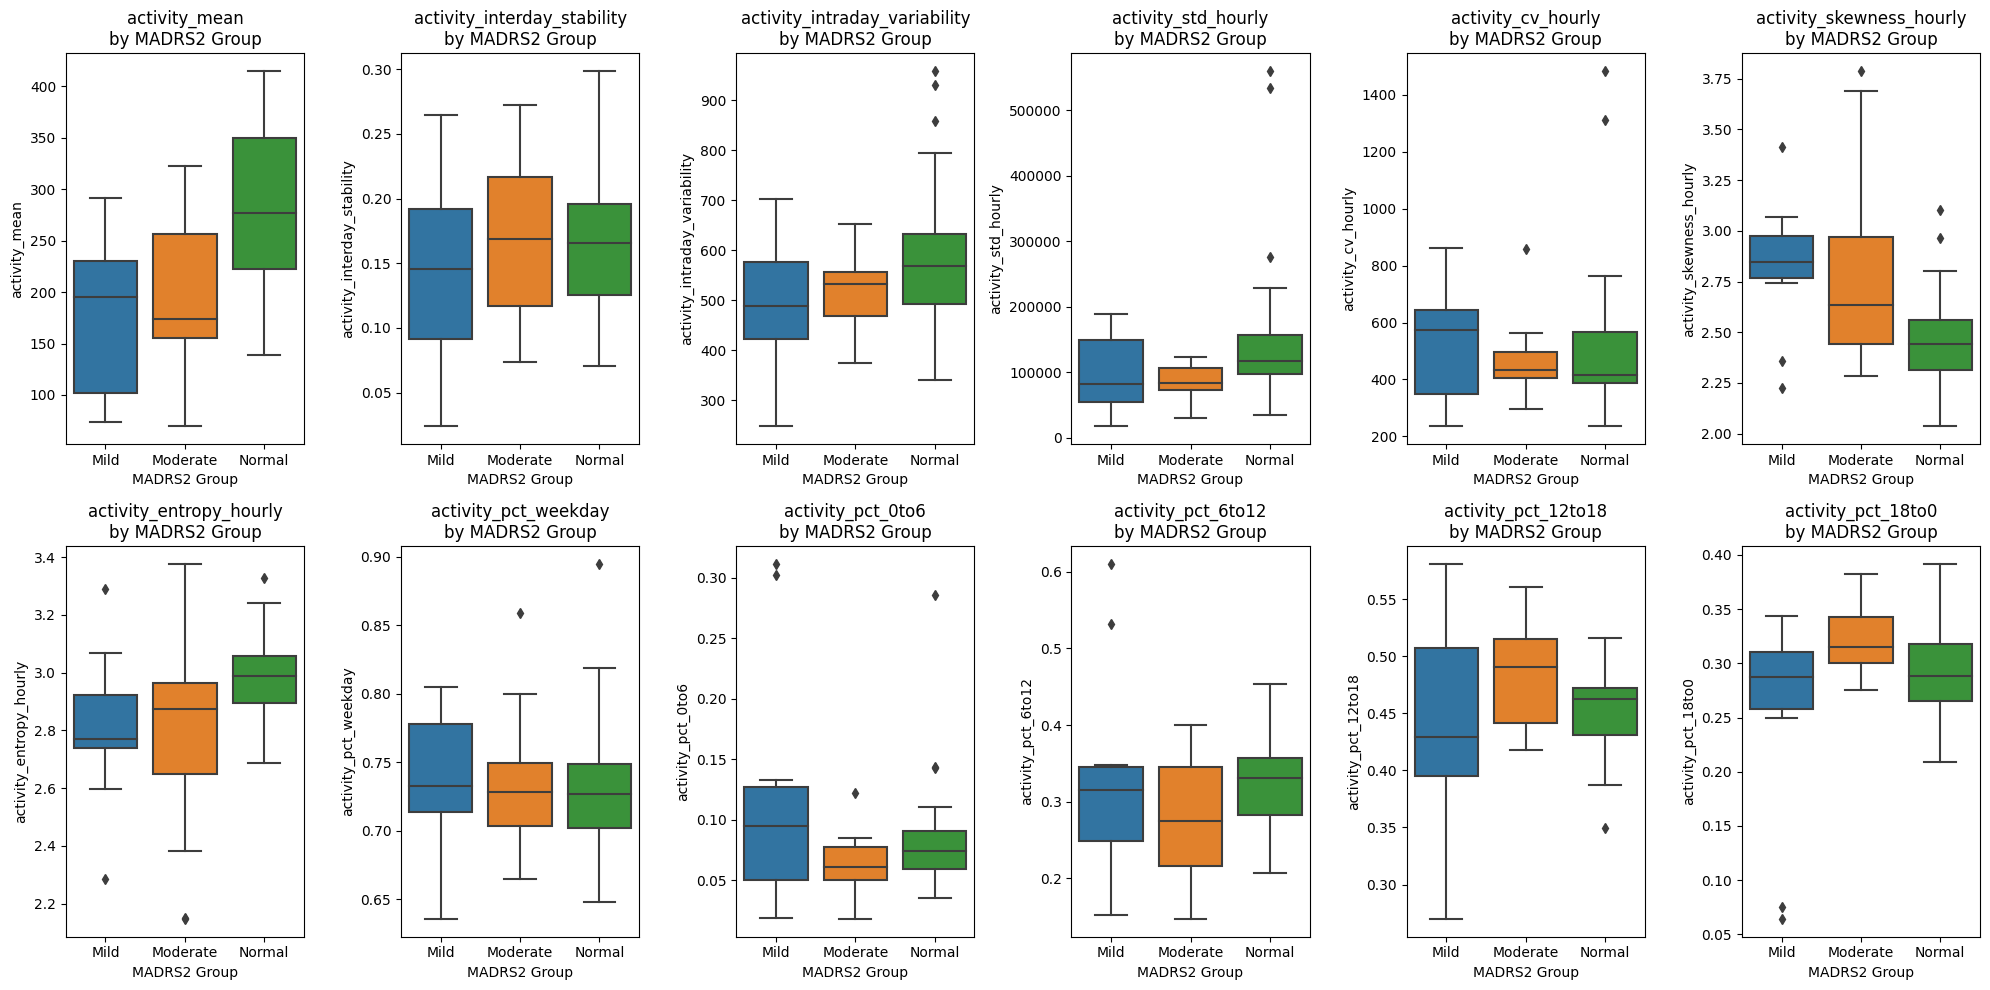

In [17]:
plot_features(df_activity_features,
              rows=2,
              cols=6,
              features=['activity_mean',
                        'activity_interday_stability',
                        'activity_intraday_variability',
                        'activity_std_hourly',                                           
                        'activity_cv_hourly',
                        'activity_skewness_hourly',
                        'activity_entropy_hourly',
                        'activity_pct_weekday',
                        'activity_pct_0to6',
                        'activity_pct_6to12',
                        'activity_pct_12to18',
                        'activity_pct_18to0'],
                figsize=(20, 10))
                        

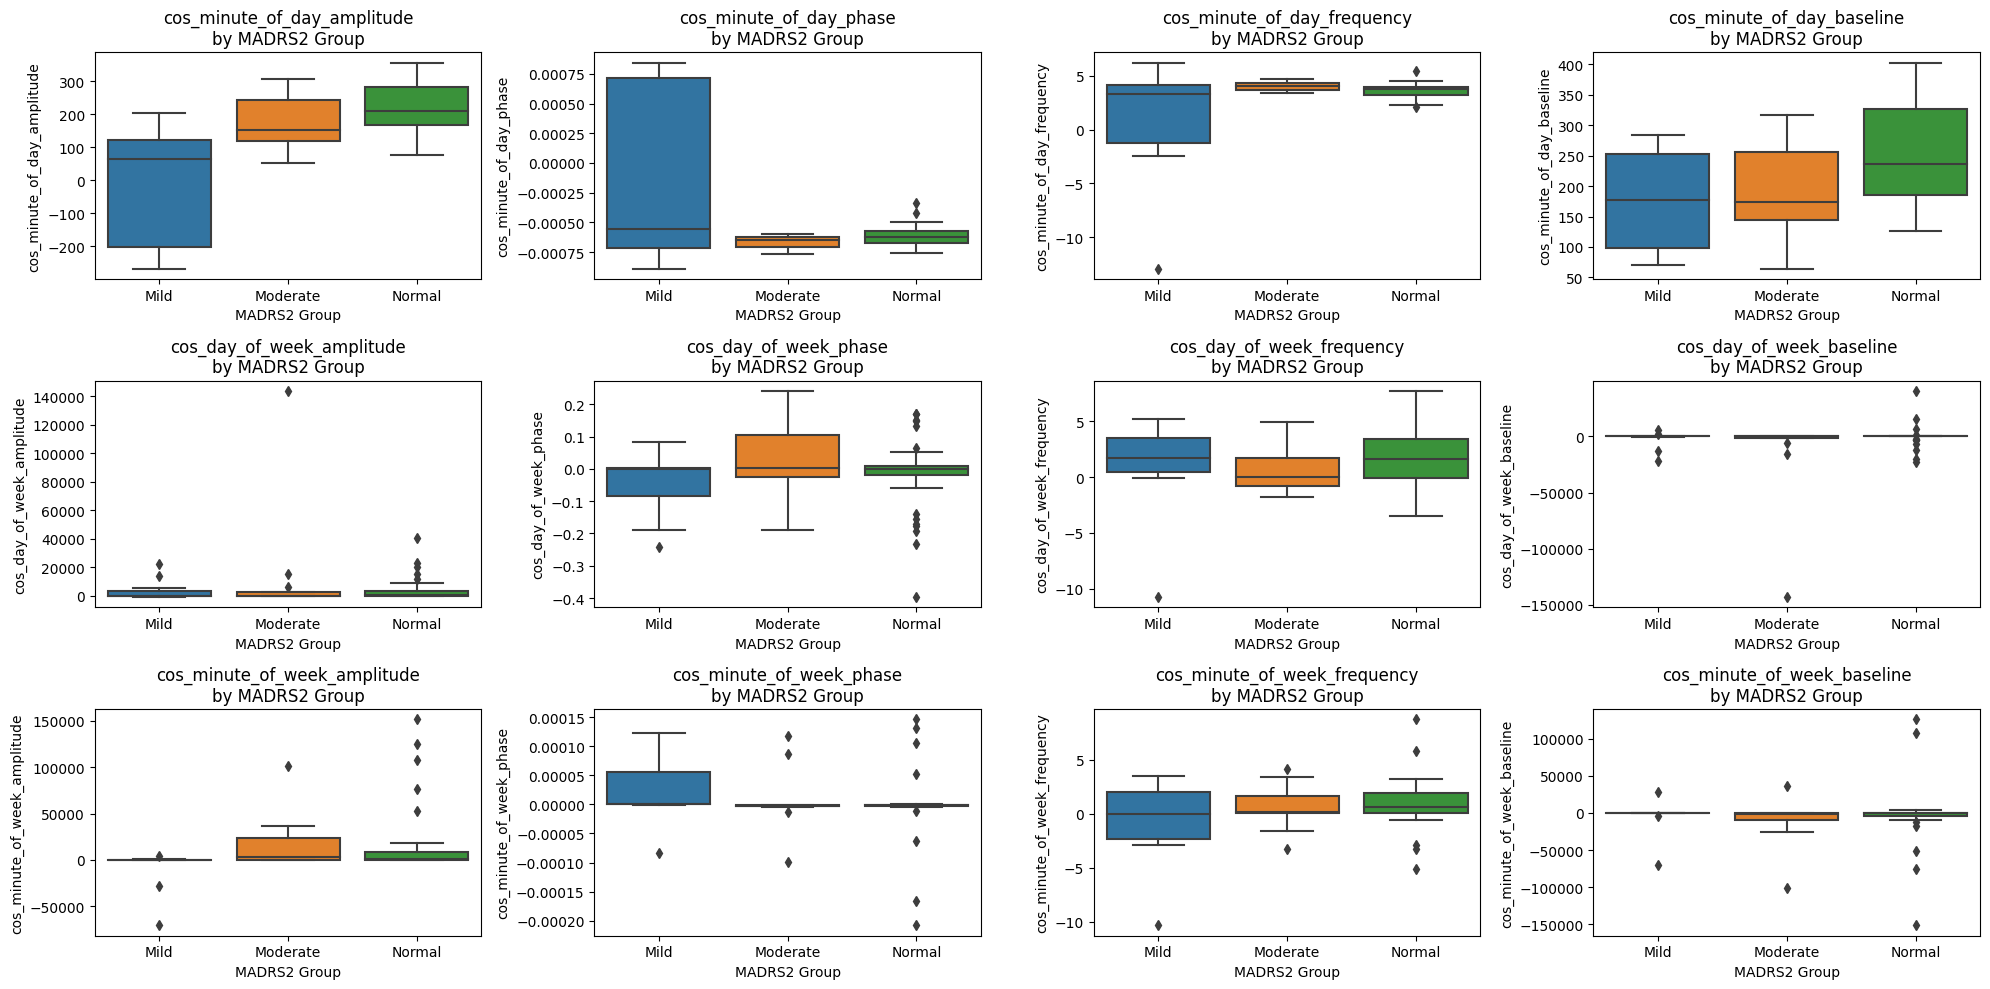

In [18]:
plot_features(df_activity_features,
              rows=3,
              cols=4,
              features=['cos_minute_of_day_amplitude',
                        'cos_minute_of_day_phase',
                        'cos_minute_of_day_frequency',
                        'cos_minute_of_day_baseline',
                        'cos_day_of_week_amplitude',
                        'cos_day_of_week_phase',
                        'cos_day_of_week_frequency',
                        'cos_day_of_week_baseline',
                        'cos_minute_of_week_amplitude',
                        'cos_minute_of_week_phase',
                        'cos_minute_of_week_frequency',
                        'cos_minute_of_week_baseline'],
                figsize=(20, 10))

Key findings:
1. Mean activity distinguishes between groups
1. Both interday stability and intraday stability appear to be predictive
1. More meaningful differences for coefficient of variation (cv) than for standard deviation - helps to distinguish between mild and moderate
1. Kurtosis and skewness seem somewhat similar. Distribution of skewness in 'moderate' is such that kurtosis maybe a better metric
1. Distribution of activity in terms of weekend vs. weekday split does not appear to distinguish between groups
1. Distribution of activity in terms of hours distinguishes between groups: Each class appears to have distinct distribution of activity
1. Cosinor parameters differ between the groups, though many overlap with one another

#### Activity/Inactivity Bout Features

To calculate features based on activity/inactivity bouts, we need to first create new dataframes where each row corresponds to a bout of activity or inactivity before applying aggregating functions to these dataframes.

Based on the search results, here are some good minimum bout duration thresholds and activity thresholds using Actiwatch data:

- Minimum bout duration threshold: 3 minutes[1]
- Activity thresholds:
  - Moderate-to-vigorous physical activity (MVPA) threshold: ≥500 counts per minute (cpm), ≥1000 cpm, ≥2000 cpm, and ≥3000 cpm[1][2][3]
  - Minimum threshold for activity duration: 10 minutes[4]

Citations:
[1] https://www.nature.com/articles/s41366-018-0152-8
[2] https://ijbnpa.biomedcentral.com/articles/10.1186/1479-5868-11-34
[3] https://www.sciencedirect.com/science/article/pii/S2211335516301231
[4] https://www.physio-pedia.com/images/c/c7/Quidelines_for_interpreting_the_IPAQ.pdf
[5] https://health.gov/sites/default/files/2019-09/07_F-1_Physical-Activity_Behaviors_Steps_Bouts_and_High_Intensity_Training.pdf

By Perplexity at https://www.perplexity.ai/search/26b5831c-6c47-4589-ba73-5d0c06cbd0ed

In [19]:
def make_bout_dfs(data, activity_threshold=200, duration_threshold=3):
    """
    Creates two dataframes, one for activity bouts and one for inactivity bouts from time-series activity data
    Each contains bouts numbered by bout number, with duration of each bout.

    Params:
        data: DataFrame containing time-series activity data
        activity_threshold: Threshold for activity level to be considered an activity bout
        duration_threshold: Threshold for duration of activity bouts to be considered valid

    Returns:
        df_activity_bouts: DataFrame containing activity bouts
        df_inactivity_bouts: DataFrame containing inactivity bouts
    """
    
    # Keep only relevant columns
    df_activity = data[['number', 'madrs2_grouped', 'madrs2_grouped_ord', 'timestamp', 'activity']].copy()

    # Calculate rolling mean of activity levels over a window of 3 minutes
    df_activity['activity_mean'] = df_activity['activity'].rolling(window=3).mean()

    # Identify whether the activity level is above the activity threshold
    df_activity['activity_bout'] = df_activity['activity_mean'] >= activity_threshold

    # Number the bouts
    df_activity['bout_num'] = (df_activity['activity_bout'] != df_activity['activity_bout'].shift(1)).cumsum()

    # Add a new column, activity_bout_num and inactivity_bout_num that takes the value for bout_num if activity_bout is True or False, respectively
    df_activity['activity_bout_num'] = df_activity['bout_num'].where(df_activity['activity_bout'])
    df_activity['inactivity_bout_num'] = df_activity['bout_num'].where(~df_activity['activity_bout'])

    # Calculate duration of each bout
    df_activity['activity_bout_duration'] = df_activity.groupby('activity_bout_num')['timestamp'].transform(lambda x: (x.max() - x.min()).seconds / 60)
    df_activity['inactivity_bout_duration'] = df_activity.groupby('inactivity_bout_num')['timestamp'].transform(lambda x: (x.max() - x.min()).seconds / 60)

    # Set duration to NaN if activity_bout_duration is less than duration_threshold
    df_activity.loc[df_activity['activity_bout_duration'] < duration_threshold, 'activity_bout_duration'] = np.nan
    df_activity.loc[df_activity['inactivity_bout_duration'] < duration_threshold, 'inactivity_bout_duration'] = np.nan

    # Set activity_bout_num to NaN if activity_bout_duration is less than duration_threshold
    df_activity.loc[df_activity['activity_bout_duration'].isna(), 'activity_bout_num'] = np.nan
    df_activity.loc[df_activity['inactivity_bout_duration'].isna(), 'inactivity_bout_num'] = np.nan

    # Apply rank to activity_bout_num and inactivity_bout_num to make this 1, 2, 3, etc.,
    df_activity['activity_bout_num'] = df_activity['activity_bout_num'].rank(method='dense')
    df_activity['inactivity_bout_num'] = df_activity['inactivity_bout_num'].rank(method='dense')

    # Create a new dataframe based on df_activity that is grouped by activity_bout_num and inactivity_bout_num, only keeping the first row for each activity_bout_num to avoid duplication
    df_activity_bouts = df_activity.groupby('activity_bout_num').first().reset_index()
    df_inactivity_bouts = df_activity.groupby('inactivity_bout_num').first().reset_index()

    return df_activity_bouts, df_inactivity_bouts

df_activity_bouts, df_inactivity_bouts = make_bout_dfs(df_merged)

/var/folders/v5/yt7ng4cx6bg_z_j227f15vsw0000gn/T/ipykernel_38965/3434072152.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


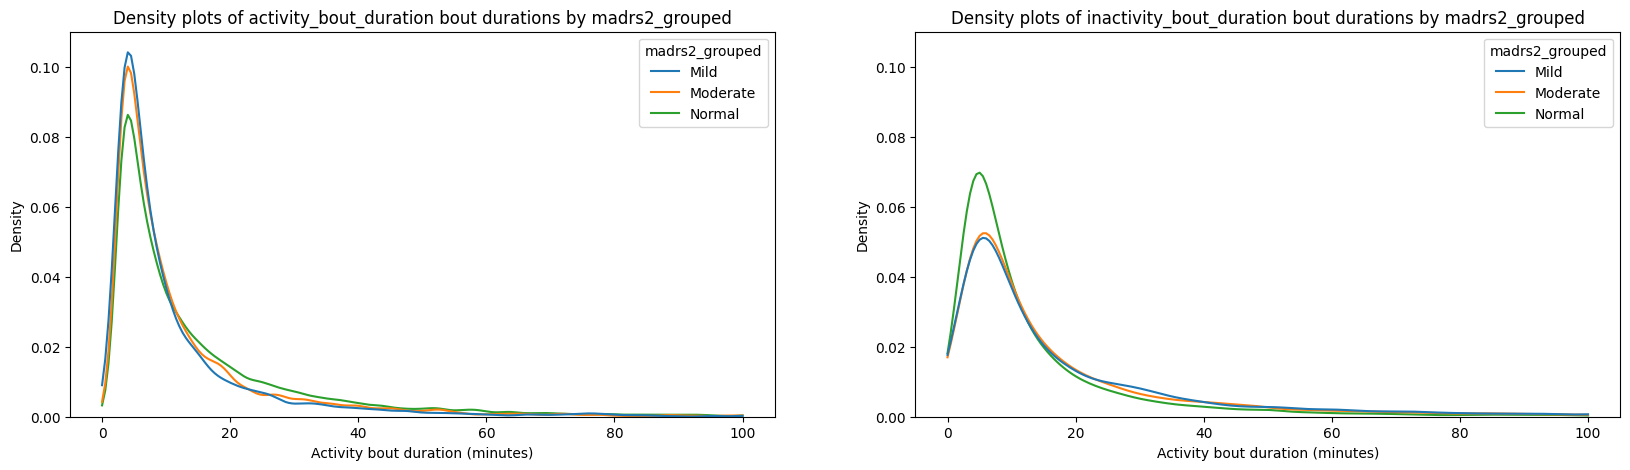

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,5))
plot_bout_durations(df_activity_bouts, xcol='activity_bout_duration', ax=ax1)
plot_bout_durations(df_inactivity_bouts, xcol='inactivity_bout_duration', ax=ax2)
ax1.set_ylim(0, 0.11)
ax2.set_ylim(0, 0.11)
fig.show()

From the above it looks like the kurtosis and skew may be different between the normal vs. depressed patients. Depressed patients seem to have shorter active bout durations and longer inactive bout durations

In [21]:
def calculate_bout_features(df_activity_bouts, df_inactivity_bouts):
    """
    Group data by number and calculate bout-based features for each number

    Params:
        df_activity_bouts: DataFrame containing activity bouts
        df_inactivity_bouts: DataFrame containing inactivity bouts

    Returns:
        df_bout_features: DataFrame containing bout-based features
    """

    # For each number, calculate the mean duration of activity and inactivity bout durations
    bout_act_dur_mean = df_activity_bouts.groupby('number')['activity_bout_duration'].mean()
    bout_inact_dur_mean = df_inactivity_bouts.groupby('number')['inactivity_bout_duration'].mean()

    # Standard deviation of activity and inactivity bout durations
    bout_act_dur_std = df_activity_bouts.groupby('number')['activity_bout_duration'].std()
    bout_inact_dur_std = df_inactivity_bouts.groupby('number')['inactivity_bout_duration'].std()

    # Coefficient of variation of activity and inactivity bout durations
    bout_act_dur_cv = bout_act_dur_std / bout_act_dur_mean
    bout_inact_dur_cv = bout_inact_dur_std / bout_inact_dur_mean
    
    # Kurtosis of activity and inactivity bouts
    bout_act_dur_kurtosis = df_activity_bouts.groupby('number')['activity_bout_duration'].apply(pd.DataFrame.kurtosis)
    bout_inact_dur_kurtosis = df_inactivity_bouts.groupby('number')['inactivity_bout_duration'].apply(pd.DataFrame.kurtosis)

    # Skewness of activity and inactivity bouts
    bout_act_dur_skew = df_activity_bouts.groupby('number')['activity_bout_duration'].apply(pd.DataFrame.skew)
    bout_inact_dur_skew = df_inactivity_bouts.groupby('number')['inactivity_bout_duration'].apply(pd.DataFrame.skew)

    # Entropy of activity and inactivity bouts
    bout_act_dur_entropy = df_activity_bouts.groupby('number')['activity_bout_duration'].apply(stats.entropy)
    bout_inact_dur_entropy = df_inactivity_bouts.groupby('number')['inactivity_bout_duration'].apply(stats.entropy)

    # Number of bouts of activity and inactivity per day
    bout_act_num = df_activity_bouts.groupby('number')['activity_bout_num'].count() / df_merged.groupby('number')['day_after_first'].max()
    bout_inact_num = df_inactivity_bouts.groupby('number')['inactivity_bout_num'].count() / df_merged.groupby('number')['day_after_first'].max()

    # Create new DataFrame with columns 'number', 'activity_bouts' and 'inactivity_bouts'
    df_bout_features = pd.DataFrame({'number':bout_act_dur_mean.index,
                                    'bout_act_num':bout_act_num.values,
                                    'bout_act_dur_mean':bout_act_dur_mean.values,
                                    'bout_act_dur_std':bout_act_dur_std.values,
                                    'bout_act_dur_cv':bout_act_dur_cv.values,
                                    'bout_act_dur_kurtosis': bout_act_dur_kurtosis.values,
                                    'bout_act_dur_skew': bout_act_dur_skew.values,
                                    'bout_act_dur_entropy': bout_act_dur_entropy.values,
                                    'bout_inact_num':bout_inact_num.values,
                                    'bout_inact_dur_mean':bout_inact_dur_mean.values,
                                    'bout_inact_dur_std':bout_inact_dur_std.values,
                                    'bout_inact_dur_cv':bout_inact_dur_cv.values,
                                    'bout_inact_dur_kurtosis': bout_inact_dur_kurtosis.values,
                                    'bout_inact_dur_skew': bout_inact_dur_skew.values,
                                    'bout_inact_dur_entropy': bout_inact_dur_entropy.values                                
                                    })
    
    # Add MADRS2_grouped column to df_bout_features
    df_bout_features = pd.merge(df_bout_features, df_merged[['number', 'madrs2_grouped']], on=['number'])

    # Remove duplicates
    df_bout_features = df_bout_features.drop_duplicates(subset=['number'])
    
    return df_bout_features

df_bout_features = calculate_bout_features(df_activity_bouts, df_inactivity_bouts)
df_bout_features.head()

number  bout_act_num  bout_act_dur_mean  bout_act_dur_std  \
0       condition_1     33.000000          13.479339         66.599417   
17279  condition_10     27.222222          25.906122         44.416750   
31678  condition_11     23.571429          10.981818          9.170107   
53277  condition_12     33.000000          11.515152         12.516208   
71996  condition_13     41.928571          13.521295         15.757683   

       bout_act_dur_cv  bout_act_dur_kurtosis  bout_act_dur_skew  \
0             4.940852             339.489631          18.155197   
17279         1.714527              85.683556           7.763403   
31678         0.835026               3.195085           1.772614   
53277         1.086934              14.890979           3.300979   
71996         1.165398              15.601526           3.217821   

       bout_act_dur_entropy  bout_inact_num  bout_inact_dur_mean  \
0                  4.664714       35.545455            30.368286   
17279              4.841926       20.333333            38.792350   
31678              5.514034       25.857143            45.690608   
53277              5.592052       36.250000            28.011494   
71996              5.918785       35.071429            25.356415   

       bout_inact_dur_std  bout_inact_dur_cv  bout_inact_dur_kurtosis  \
0               78.551779           2.586638                26.283712   
17279           85.684641           2.208803                12.928130   
31678          112.844307           2.469748                22.338060   
53277           62.078420           2.216177                19.911087   
71996           79.032060           3.116847               163.692901   

       bout_inact_dur_skew  bout_inact_dur_entropy madrs2_grouped  
0                 5.029551                4.747316           Mild  
17279             3.599703                4.043482       Moderate  
31678             4.516316                4.637721       Moderate  
53277             4.359810                5.026175       Moderate  
71996            10.843546                4.908043           Mild

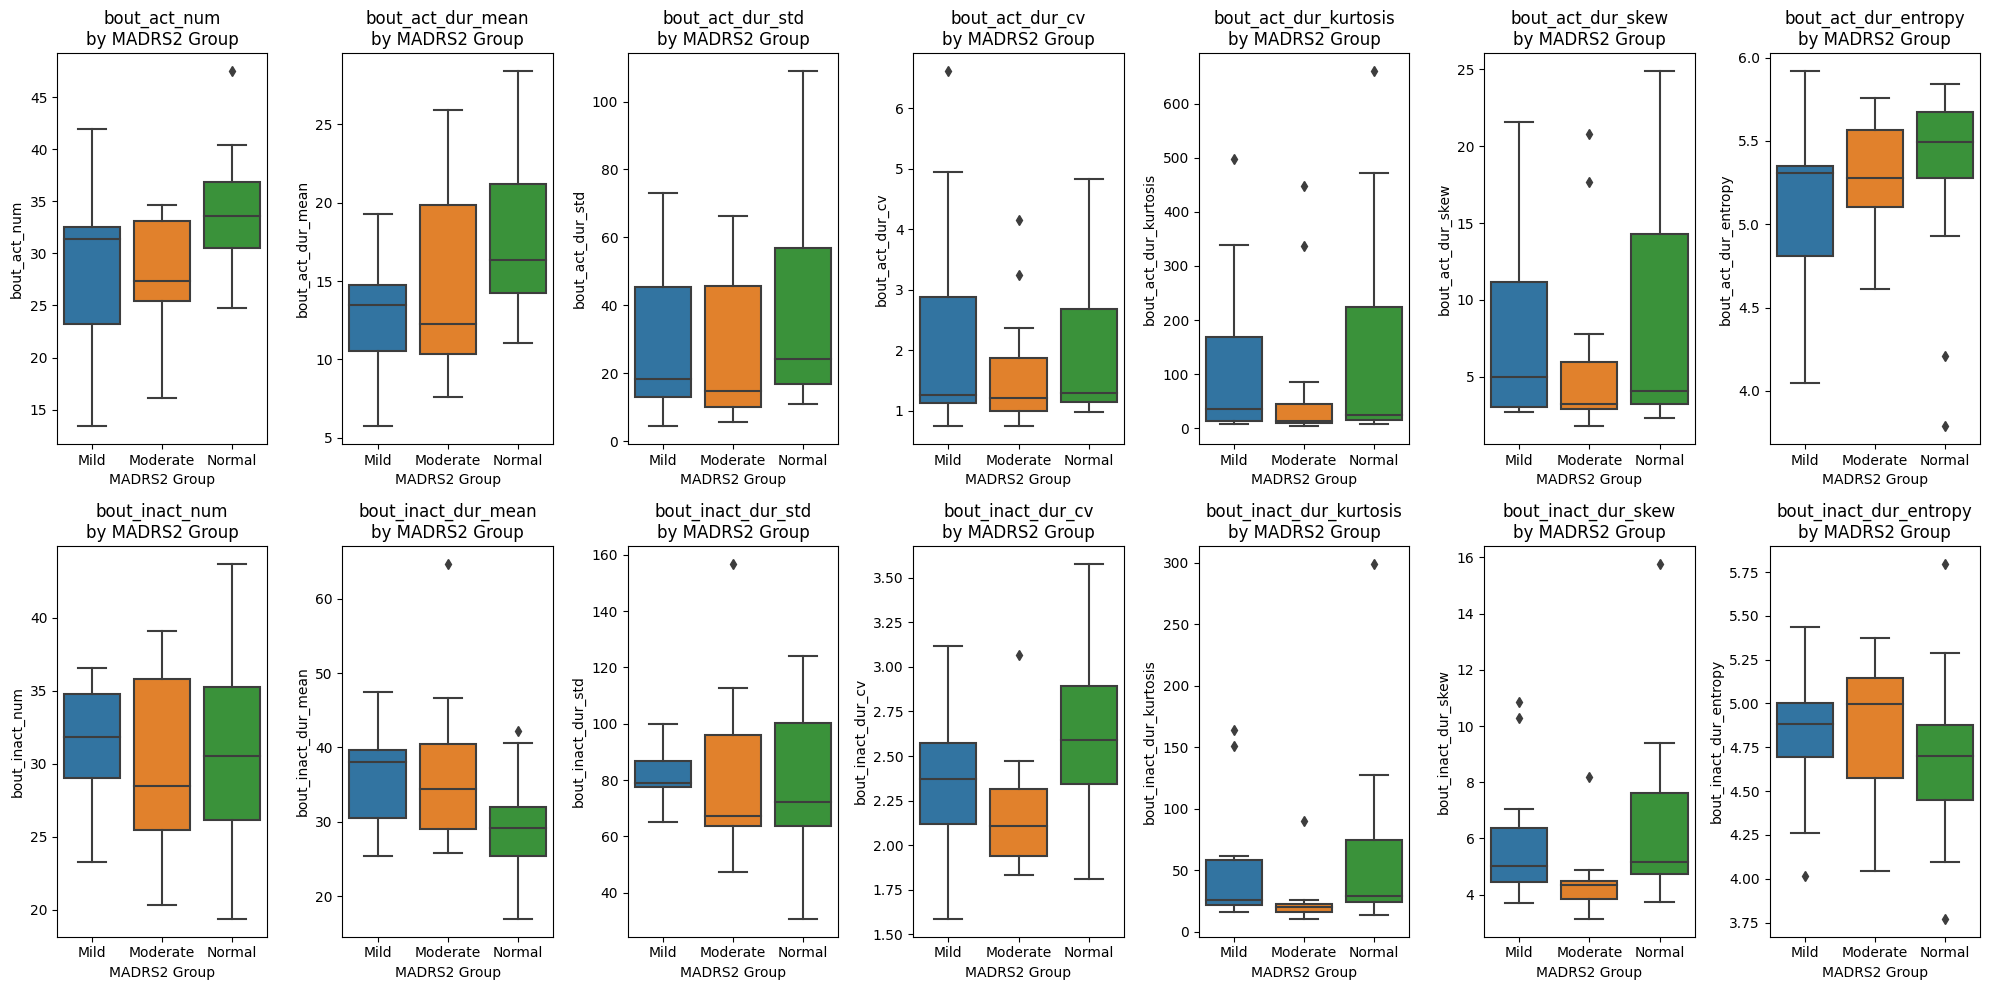

In [22]:
plot_features(data = df_bout_features, rows=2, cols=7, features=df_bout_features.columns[1:-1])                                                                 

### Merge all the activity-based features together into a single dataframe

In [23]:
# Merge df_bout_features with df, dropping 'madrs2_grouped from df_bout_features'
df_features = pd.merge(df_activity_features, df_bout_features.drop('madrs2_grouped', axis=1), on=['number'])

## Feature Selection

### Composite decision-tree and greedy feature selection

The following code uses two algorithms to select the m

In [24]:
def feature_selection_decision_tree(df, cols_to_drop=['number', 'madrs2_grouped', 'Normal', 'Mild', 'Moderate'], y_col='madrs2_grouped_ord'):
    """
    Uses a decision tree to calculate feature importances and returns a DataFrame with the feature names and importances.

    Params:
        df: DataFrame with features and MADRS2 Groups (Normal, Mild, Moderate)
        cols_to_drop: List of columns to drop from df
        y_col: Name of column containing MADRS2 Groups (Ordinal)
        
    Returns:
        df_importances: DataFrame with feature names and importances
    """
    # Drop 'number'
    df = df.drop(cols_to_drop, axis=1)
    
    # Set up and fit Decision Tree
    y = df[y_col]
    X = df.drop(columns=y_col)
    tree = DecisionTreeClassifier(class_weight='balanced', random_state=0)
    tree.fit(X, y)

    # Get feature importances and names
    feature_importances = tree.feature_importances_
    feature_names = X.columns

    # Combine importances and names into DataFrame and sort by importance
    df_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances,
    }).sort_values(by='importance', ascending=False)

    # Reset index of df_importances
    df_importances = df_importances.reset_index(drop=True)

    # Drop rows with importance of 0
    df_importances = df_importances[df_importances['importance'] > 0]

    return df_importances

def feature_selection_greedy(df, cols_to_drop=['number', 'madrs2_grouped', 'madrs2_grouped_ord'], corr_drop_threshold=0.8):
    """
    Uses a greedy algorithm to select features that are highly correlated with MADRS2 Group and not highly correlated with each other.

    Params:
        df: DataFrame with features and MADRS2 Groups (Normal, Mild, Moderate)
        cols_to_drop: List of columns to drop from df
        corr_drop_threshold: Threshold for dropping highly correlated features

    Returns:
        selected_features: DataFrame with feature names and MADRS2 Group correlation
    """
    # Drop columns
    df = df.drop(cols_to_drop, axis=1)

    # Initialize a list for selected features and the correlation matrix
    selected_features = {}
    corr = df.corr().abs()

    # Calculate 'MADRS2 Predictive score' by averaging the absolute values of 'Normal', 'Mild' and 'Moderate'
    corr['madrs2_predictive_score'] = (corr['Normal'].abs() + corr['Mild'].abs() + corr['Moderate'].abs())/3

    # Delete 'Normal' 'Mild' 'Moderate' columns
    corr = corr.drop(columns=['Normal', 'Mild', 'Moderate'])

    # Remove 'Normal' 'Mild' 'Moderate' and 'madrs2_predictive_score' rows
    corr = corr.drop(index=['Normal', 'Mild', 'Moderate'])

    # Greedy feature selection
    while not corr.empty:
        # Select feature with highest 'madrs2_predictive_score'
        next_feature = corr['madrs2_predictive_score'].idxmax()
        
        # Add selected feature and its 'madrs2_predictive_score' to the dataframe
        selected_features[next_feature] = corr.loc[next_feature, 'madrs2_predictive_score']

        # Remove selected feature and features highly correlated with it
        correlated_features = corr[next_feature][corr[next_feature] > corr_drop_threshold].index
        corr = corr.drop(columns=[next_feature] + list(correlated_features))
        corr = corr.drop(index=[next_feature] + list(correlated_features))

    # Convert selected_features to a DataFrame, calling the first column 'feature' and the second column 'madrs2_predictive_score'
    selected_features = pd.DataFrame(list(selected_features.items()), columns=['feature', 'madrs2_predictive_score'])
    
    return selected_features

df_greedy_feature = feature_selection_greedy(df_features, corr_drop_threshold=0.9)
df_decision_tree_feature = feature_selection_decision_tree(df_features)


In [25]:
def merge_feature_selection(df_greedy = df_greedy_feature, df_decision_tree = df_decision_tree_feature):
    """
    Merges the greedy and decision tree feature selection results and calculates an average score for each feature.

    Params:
        df_greedy: DataFrame with features and MADRS2 Predictive Scores from greedy feature selection
        df_decision_tree: DataFrame with features and importances from decision tree feature selection
        
    Returns:
        df_feature_selection: DataFrame with features, individual and average scores
    """
    # Merge greedy and decision tree feature selection
    df_feature_selection = pd.merge(df_greedy_feature, df_decision_tree, how='outer', on='feature', suffixes=('_greedy', '_decision_tree'))
    df_feature_selection.columns = ['feature', 'madrs2_predictive_score_greedy', 'importance_decision_tree']

    # Replace nan with 0
    df_feature_selection = df_feature_selection.fillna(0)

    # Normalize the scores using sklearn's minmax scaler
    scaler = MinMaxScaler()
    df_feature_selection[['madrs2_predictive_score_greedy', 'importance_decision_tree']] = scaler.fit_transform(df_feature_selection[['madrs2_predictive_score_greedy', 'importance_decision_tree']])

    # Calculate average score as a new column
    df_feature_selection['average_score'] = (df_feature_selection['madrs2_predictive_score_greedy'] + df_feature_selection['importance_decision_tree']) / 2

    # Sort by average score
    df_feature_selection = df_feature_selection.sort_values(by='average_score', ascending=False)

    # Reindex
    df_feature_selection = df_feature_selection.reset_index(drop=True)

    # Make each column display in 2 decimal places
    df_feature_selection = df_feature_selection.round(2)

    return df_feature_selection

df_feature_scores = merge_feature_selection(df_greedy_feature, df_decision_tree_feature)

In [26]:
# Create new DataFrame with only the top 25 selected features
def create_top_features_df(df, df_feature_scores=df_feature_scores, top_n=len(df_feature_scores)):
    """
    Creates a new DataFrame with only the top n features, number and madrs2 grouping columns

    Params:
        df: DataFrame with features, number and MADRS2 Groups (Normal, Mild, Moderate)
        df_feature_scores: DataFrame with feature names sorted by average score per feature

    Returns:
        df_top_features: DataFrame with top n features, number and MADRS2 Groups (Normal, Mild, Moderate)
    """
    # Create a list of columns to keep
    cols_to_keep = list(['number', 'madrs2_grouped', 'madrs2_grouped_ord', 'Normal', 'Mild', 'Moderate'])

    # Take top n features from df_feature_scores
    top_features = list(df_feature_scores['feature'][:top_n])

    # Sort top_features alphabetically
    top_features.sort()
    
    # Add top features to cols_to_keep
    cols_to_keep.extend(top_features)

    # Create a new DataFrame with only the top features
    df_top_features = df[cols_to_keep].copy()

    return df_top_features

df_selected_features = create_top_features_df(df_features, df_feature_scores=df_feature_scores, top_n=30)
df_selected_features

number madrs2_grouped  madrs2_grouped_ord  Normal   Mild  Moderate  \
0    condition_1           Mild                   1   False   True     False   
1   condition_10       Moderate                   2   False  False      True   
2   condition_11       Moderate                   2   False  False      True   
3   condition_12       Moderate                   2   False  False      True   
4   condition_13           Mild                   1   False   True     False   
5   condition_14           Mild                   1   False   True     False   
6   condition_15           Mild                   1   False   True     False   
7   condition_16           Mild                   1   False   True     False   
8   condition_17           Mild                   1   False   True     False   
9   condition_18           Mild                   1   False   True     False   
10  condition_19       Moderate                   2   False  False      True   
11   condition_2           Mild                   1   False   True     False   
12  condition_20       Moderate                   2   False  False      True   
13  condition_21       Moderate                   2   False  False      True   
14  condition_22       Moderate                   2   False  False      True   
15  condition_23       Moderate                   2   False  False      True   
16   condition_3       Moderate                   2   False  False      True   
17   condition_4           Mild                   1   False   True     False   
18   condition_5       Moderate                   2   False  False      True   
19   condition_6           Mild                   1   False   True     False   
20   condition_7       Moderate                   2   False  False      True   
21   condition_8           Mild                   1   False   True     False   
22   condition_9       Moderate                   2   False  False      True   
23     control_1         Normal                   0    True  False     False   
24    control_10         Normal                   0    True  False     False   
25    control_11         Normal                   0    True  False     False   
26    control_12         Normal                   0    True  False     False   
27    control_13         Normal                   0    True  False     False   
28    control_14         Normal                   0    True  False     False   
29    control_15         Normal                   0    True  False     False   
30    control_16         Normal                   0    True  False     False   
31    control_17         Normal                   0    True  False     False   
32    control_18         Normal                   0    True  False     False   
33    control_19         Normal                   0    True  False     False   
34     control_2         Normal                   0    True  False     False   
35    control_20         Normal                   0    True  False     False   
36    control_21         Normal                   0    True  False     False   
37    control_22         Normal                   0    True  False     False   
38    control_23         Normal                   0    True  False     False   
39    control_24         Normal                   0    True  False     False   
40    control_25         Normal                   0    True  False     False   
41    control_26         Normal                   0    True  False     False   
42    control_27         Normal                   0    True  False     False   
43    control_28         Normal                   0    True  False     False   
44    control_29         Normal                   0    True  False     False   
45     control_3         Normal                   0    True  False     False   
46    control_30         Normal                   0    True  False     False   
47    control_31         Normal                   0    True  False     False   
48    control_32         Normal                   0    True  False     False   
49     con

In [27]:
def plot_feature_correlation(data, cols_to_drop=['number', 'madrs2_grouped'], figsize=(30, 30), simple=False, row_start=4, col_end=4, fontsize=12):
    """
    Plot a correlation heatmap of features
    
    Params:
        data: dataframe containing features to plot
        cols_to_drop: columns to drop from data before plotting
        figsize: size of heatmap
        simple: flag to indicate whether to plot a simple heatmap or not
        row_start: row to start plotting from
        col_end: column to end plotting at
        fontsize: size of font for annotations
    """
    data = data.drop(cols_to_drop, axis=1)   
    plt.figure(figsize=figsize)
    
    if simple:
        ax = sns.heatmap(data.corr().iloc[row_start:, :col_end],
                    annot=True,
                    cmap='coolwarm_r',
                    fmt='.2f',
                    annot_kws={"fontsize":fontsize},
                    linewidths=3)
    else:
        ax = sns.heatmap(data.corr(),
                    annot=True,
                    cmap='coolwarm_r',
                    fmt='.2f',
                    mask=np.triu(data.corr(), k=1))
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)


In [28]:
plot_feature_correlation(data=df_selected_features)
plot_feature_correlation(data=df_selected_features, figsize=(20, 15), fontsize=16, simple=True)